# Explore differential expression analysis results

In [47]:
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pymde
import hdbscan
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

In [48]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

## Read best DE results, filter based on number of DE genes and on-target KD effects

In [50]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')

In [4]:
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.X = np.nan_to_num(adata_de.layers['zscore'], 0)

In [51]:
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [72]:
de_summary_stats[de_summary_stats.target_name=='IL5']

target_contrast target_name condition  n_cells_target  n_up_genes  \
14397  ENSG00000113525         IL5      Rest           791.0           6   
20649  ENSG00000113525         IL5   Stim8hr           674.0           2   
26700  ENSG00000113525         IL5  Stim48hr           693.0           1   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
14397             0                 6             -0.660189   
20649             1                 3             -2.831776   
26700             0                 1             -2.993820   

       ontarget_significant   baseMean  offtarget_flag n_total_genes_category  \
14397                 False   0.745258           False          2-10 DE genes   
20649                 False  64.879451           False          2-10 DE genes   
26700                 False  43.456720           False              1 DE gene   

      ontarget_effect_category target_contrast_corrected  \
14397          no on-target KD           ENSG00000113525   
20649          no on-target KD           ENSG00000113525   
26700          no on-target KD           ENSG00000113525   

                      obs_names target_name_corrected  
14397      ENSG00000113525_Rest                   IL5  
20649   ENSG00000113525_Stim8hr                   IL5  
26700  ENSG00000113525_Stim48hr                   IL5

In [61]:
ls ../../metadata

Arce2025_Screen.csv
Freimer2022_Screen.csv
Freimer_et_al_DEseq2.h5ad
Freimer_et_al_raw.csv
IUIS-IEI-list-July-2024V2.csv
IUIS-IEI-list-for-web-site-July-2024V2.xlsx
LRZ002RHSgRNA.csv
Lambert_2018_HumanTF.csv
MONDO_0004784_genetic_associations.csv
OT-MONDO_0007915-associated-targets-6_17_2025-v25_03.tsv
README.md
Replogle2022_TableS3_perturb_clusters.xlsx
SLE_DEGs_Nakano2022.csv.gz
Schmidt2022_hits_Supplementary_table_2.xlsx
SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv
TableS4_weinstock_et_al_DE.csv
Tahoe100M_cellline_stats.csv
Umhoefer2025_FOXP3_Teff.csv
cytokine_receptors.tsv
experiments_config.yaml
figure_palettes.yaml
gene_lists/
hsa04050.json
hsa04052.json
rest_functional_group.csv
sgRNA_library_curated.csv
sgrna_df_final.csv
sgrna_df_final.parquet
th1_th2_known_regulators.yaml


In [62]:
de_summary_stats[(de_summary_stats.n_total_de_genes>30)&(de_summary_stats.n_cells_target>75)].to_csv('../../metadata/for_DE_by_guide.csv')

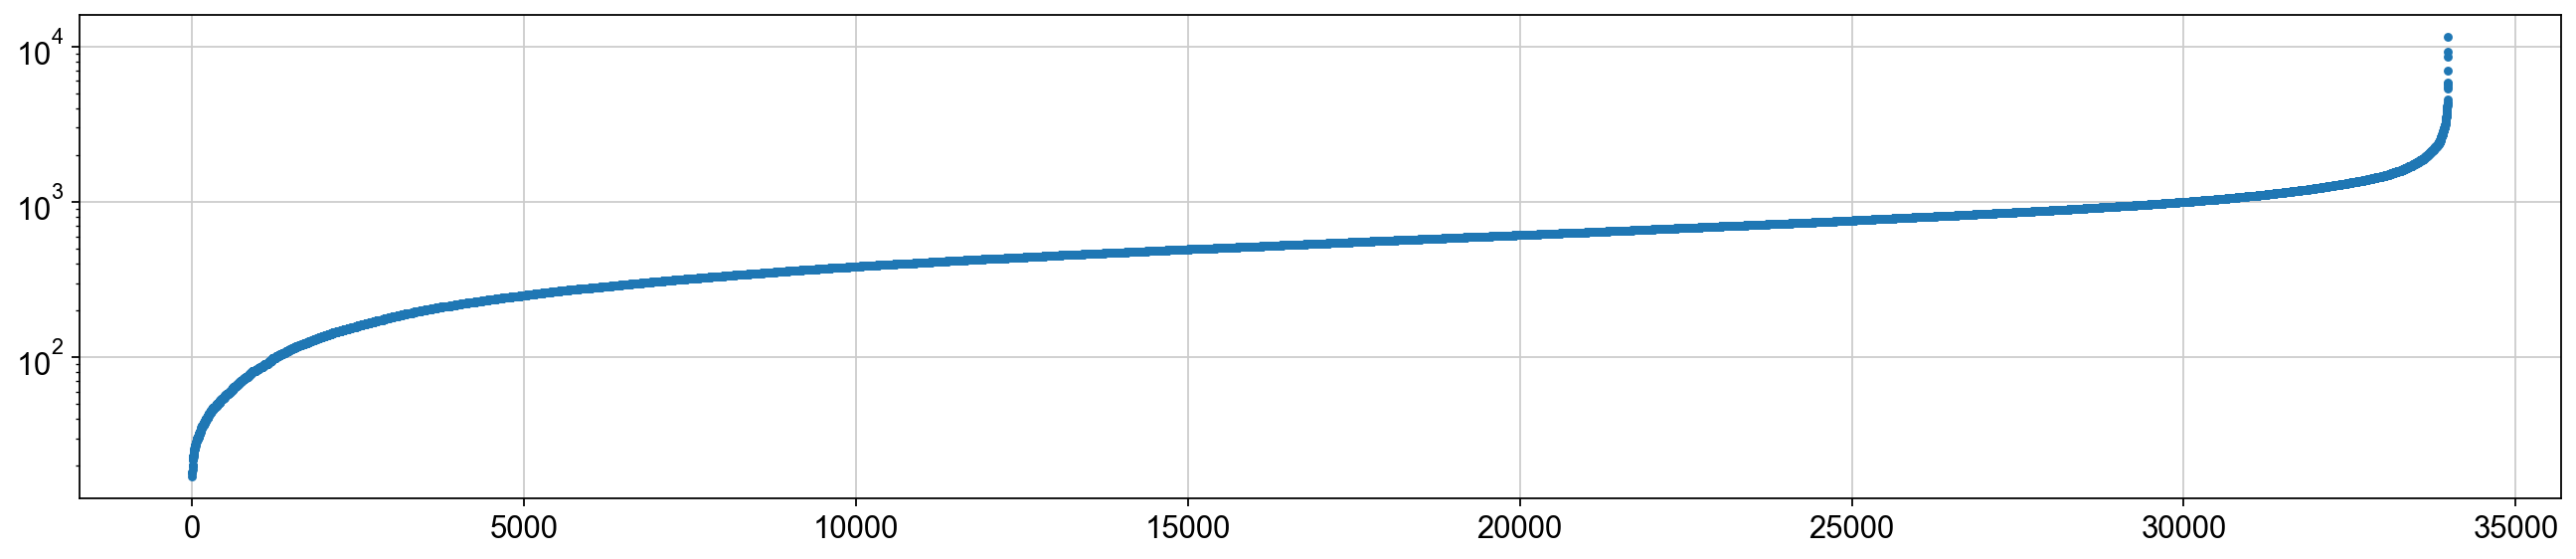

In [6]:
plt.plot(np.sort(de_summary_stats.n_cells_target), '.')
plt.yscale('log')

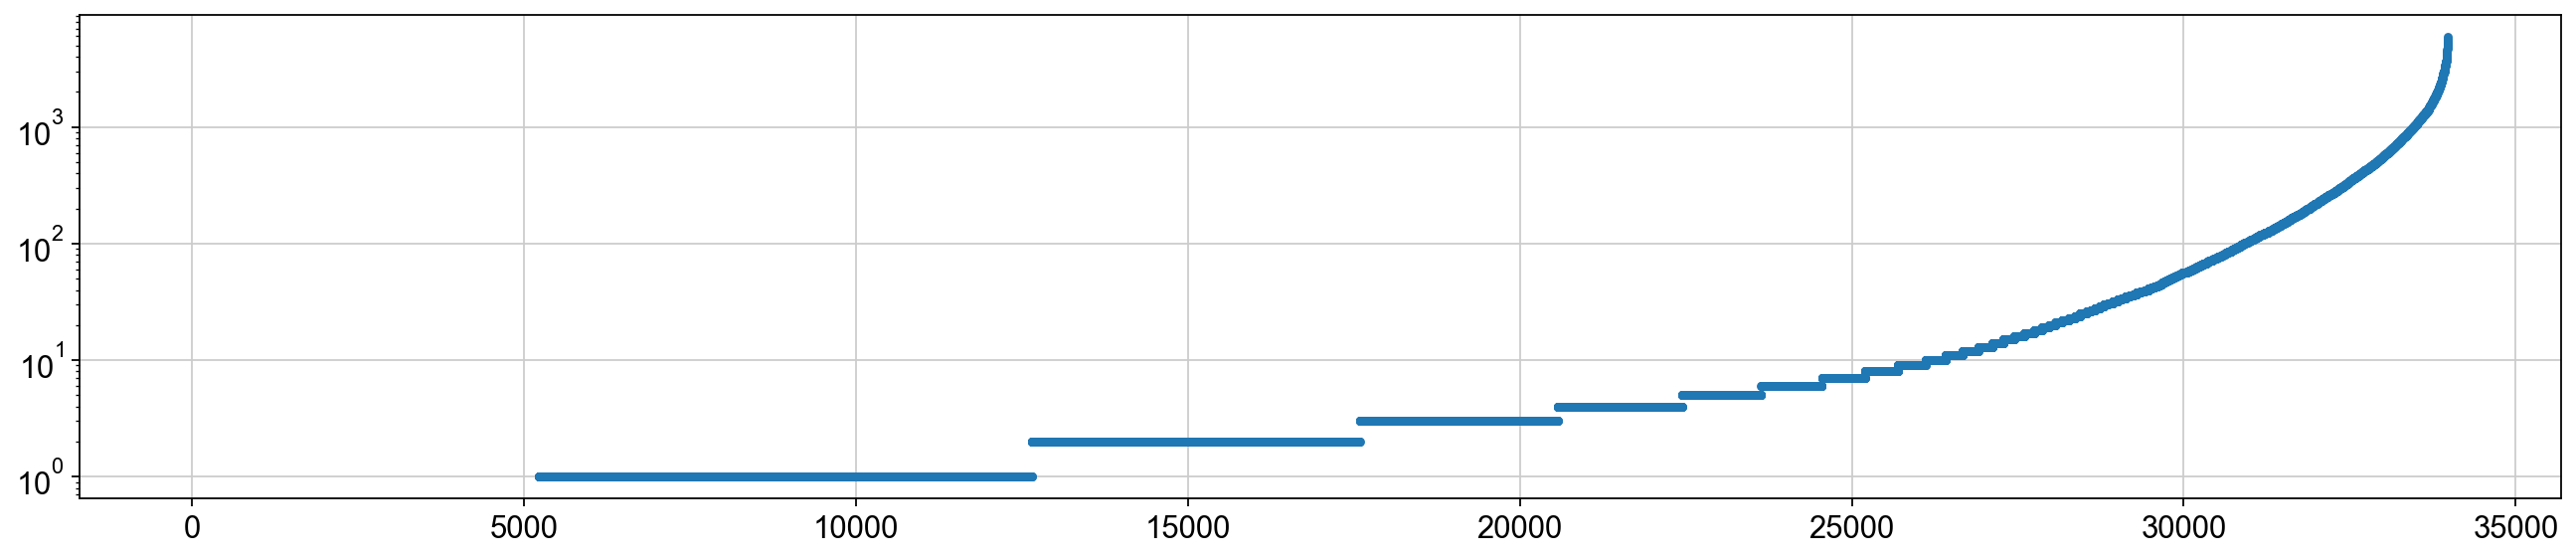

In [7]:
plt.plot(np.sort(de_summary_stats.n_total_de_genes), '.')
plt.yscale('log')

In [8]:
mask = (de_summary_stats.n_total_de_genes>50) & (de_summary_stats.n_cells_target>100)# & (de_summary_stats.ontarget_effect_category=='on-target KD')
obs_names_mask = de_summary_stats[mask].obs_names
adata_de_filtered = adata_de[adata_de.obs_names.isin(obs_names_mask)].copy()
adata_de_filtered.var_names = adata_de_filtered.var.gene_name
adata_de_filtered.X = np.nan_to_num(adata_de_filtered.layers['zscore'], 0)

In [183]:
# gene_rest = guide_effect_rest[guide_effect_rest.signif_knockdown==True].target_gene.tolist()
# gene_rest = gene_rest + de_summary_stats[(de_summary_stats.ontarget_significant==True)&(de_summary_stats.condition=='Rest')].target_name.tolist()
# obs_names_rest = adata_de_filtered[(adata_de_filtered.obs.target_contrast_gene_name.isin(gene_rest))&(adata_de_filtered.obs.culture_condition=='Rest')].obs_names
# gene_stim8hr = guide_effect_stim8hr[guide_effect_stim8hr.signif_knockdown==True].target_gene.tolist()
# gene_stim8hr = gene_stim8hr + de_summary_stats[(de_summary_stats.ontarget_significant==True)&(de_summary_stats.condition=='Stim8hr')].target_name.tolist()
# obs_names_stim8hr = adata_de_filtered[(adata_de_filtered.obs.target_contrast_gene_name.isin(gene_stim8hr))&(adata_de_filtered.obs.culture_condition=='Stim8hr')].obs_names
# gene_stim48hr = guide_effect_stim48hr[guide_effect_stim48hr.signif_knockdown==True].target_gene.tolist()
# gene_stim48hr = gene_stim48hr + de_summary_stats[(de_summary_stats.ontarget_significant==True)&(de_summary_stats.condition=='Stim48hr')].target_name.tolist()
# obs_names_stim48hr = adata_de_filtered[(adata_de_filtered.obs.target_contrast_gene_name.isin(gene_stim48hr))&(adata_de_filtered.obs.culture_condition=='Stim48hr')].obs_names
# obs_names_all = np.concatenate([obs_names_rest, obs_names_stim8hr, obs_names_stim48hr])
# adata_de_filtered = adata_de_filtered[adata_de_filtered.obs_names.isin(obs_names_all)].copy()

In [9]:
adata_de_filtered

AnnData object with n_obs × n_vars = 3621 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

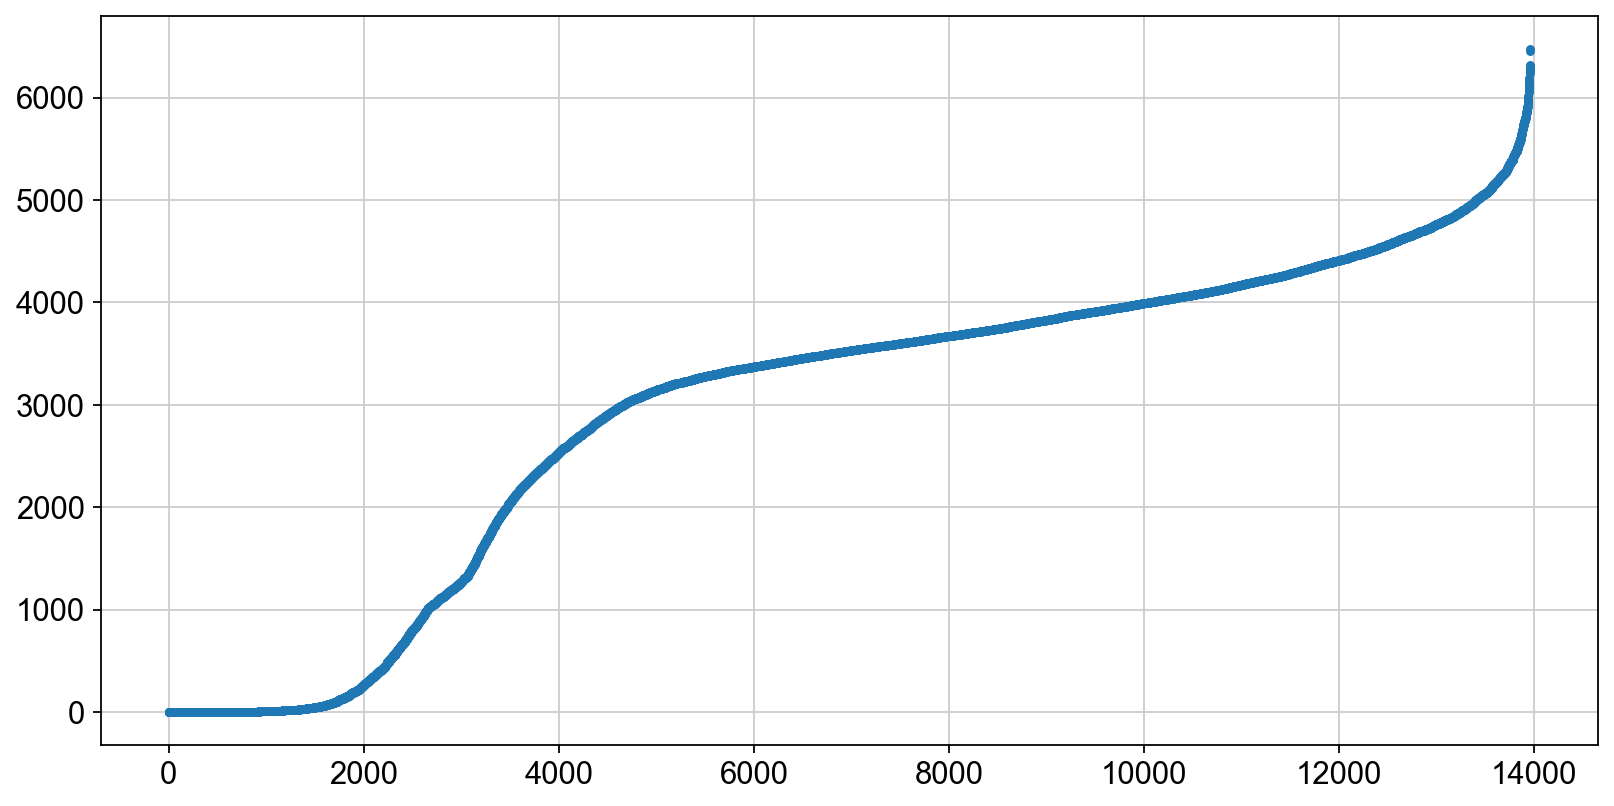

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(np.sort(np.abs(adata_de_filtered.X).sum(0)), '.')

In [77]:
adata_de_filtered = adata_de_filtered[:,np.abs(adata_de_filtered.X).sum(0)>1500].copy()

In [78]:
adata_de_filtered

AnnData object with n_obs × n_vars = 3621 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [79]:
adata_de_filtered.write_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')

In [17]:
adata_de_filtered = sc.read_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')
adata_cluster = sc.read_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')

### Simple PCA clustering

In [81]:
sc.pp.scale(adata_cluster)

In [82]:
sc.pp.pca(adata_cluster, n_comps=300)

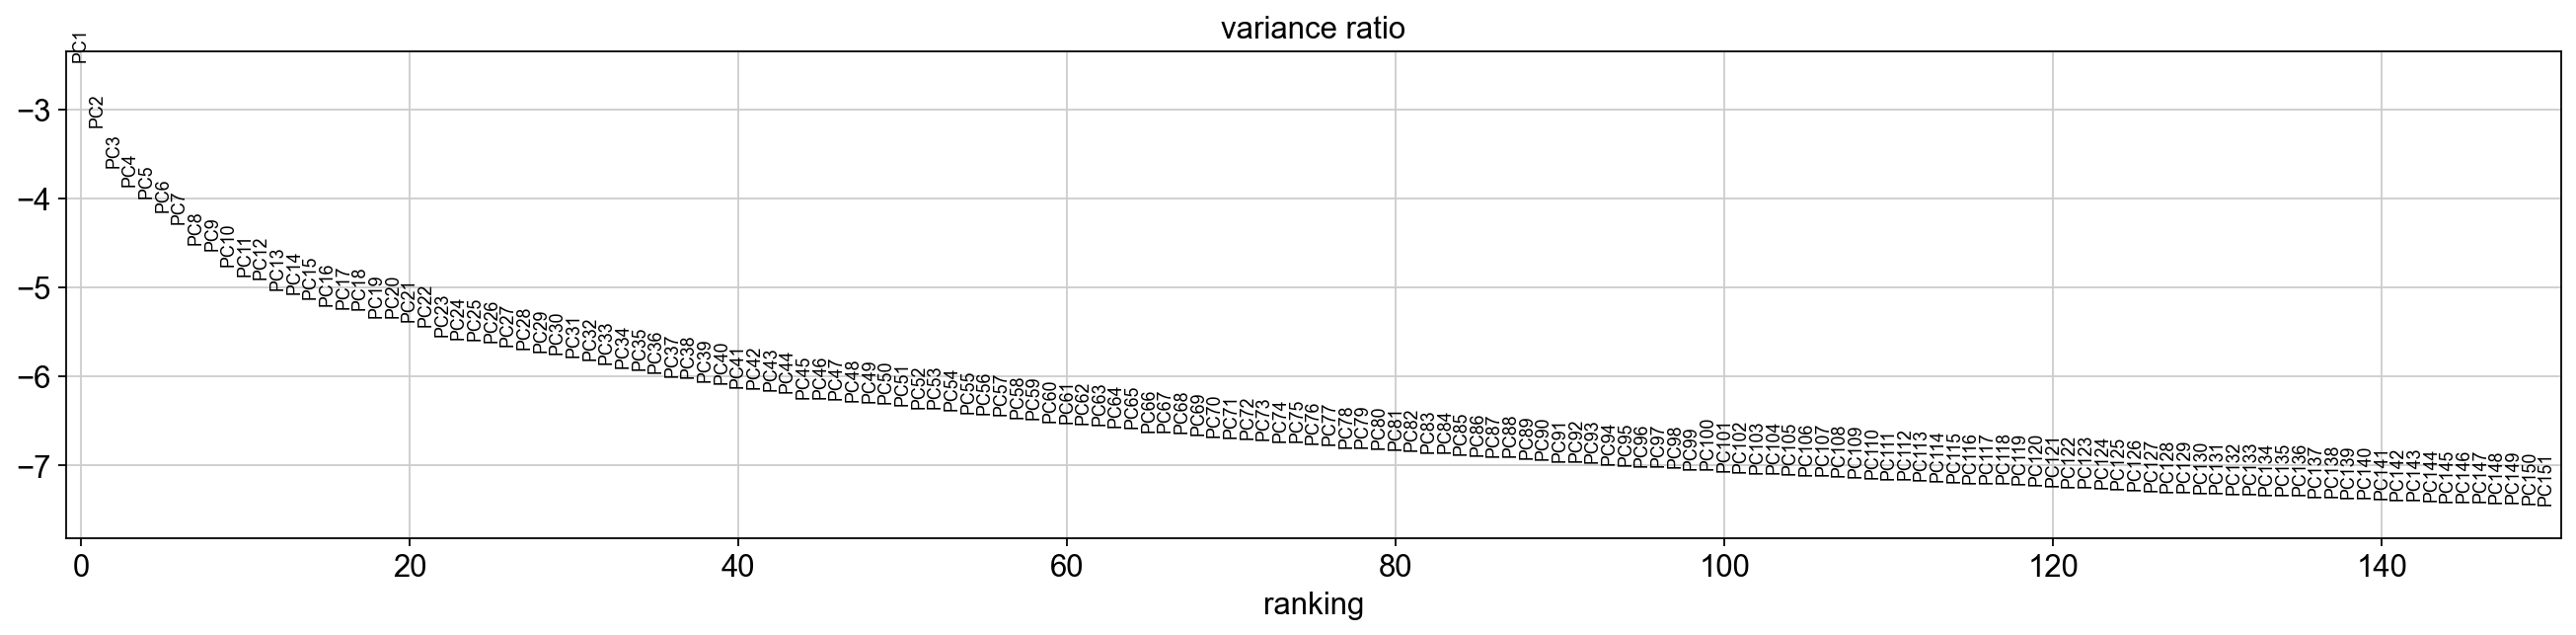

In [83]:
sc.pl.pca_variance_ratio(adata_cluster, n_pcs=150, log=True)

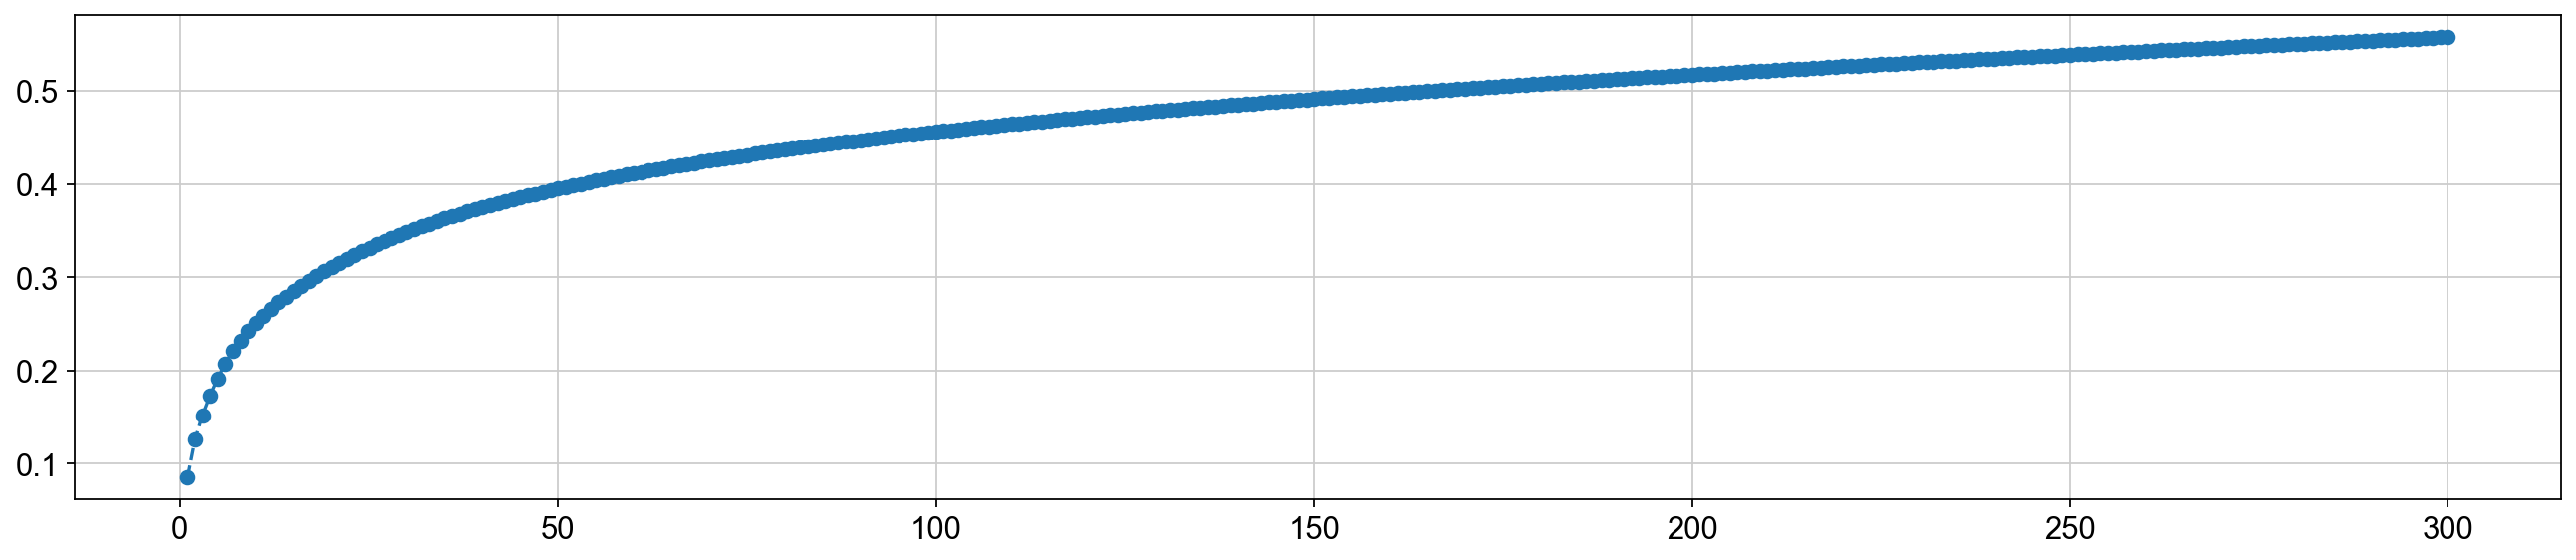

In [84]:
variance_ratio = adata_cluster.uns['pca']['variance_ratio']
cumulative_variance_ratio = np.cumsum(variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')

In [46]:
adata_final

AnnData object with n_obs × n_vars = 1959 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [45]:
adata_cluster

AnnData object with n_obs × n_vars = 3621 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [7]:
adata_cluster = sc.read_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')

In [4]:
def generate_masks(data_length: int, percentage: float, num_times: int, random_seed=42) -> List[List[bool]]:
    np.random.seed(random_seed)
    sample_size = int(data_length * (percentage / 100.0))
    masks = []
    for _ in range(num_times):
        indices = np.random.choice(data_length, size=sample_size, replace=False)
        mask = np.zeros(data_length, dtype=bool)
        mask[indices] = True
        masks.append(mask)
    return masks


def running_clustering(obs_mask, var_mask, n_comp_all=[50,100,150], n_neighbor_all=[15,31,63], resolution_all=[2,3,4]):
    """
    Running leiden clustering with parameter grid
    """
    N = len(adata_cluster)
    # Subsetting the adata
    adata_tmp = adata_cluster[obs_mask, var_mask].copy()
    # Perform PCA
    sc.pp.scale(adata_tmp)
    sc.pp.pca(adata_tmp, n_comps=max(n_comp_all))
    clustering_batch = []
    for n_comp in n_comp_all:
        for n_neighbor in n_neighbor_all:
            # Perform knn
            sc.pp.neighbors(adata_tmp, n_pcs=n_comp, n_neighbors=n_neighbor, random_state=42)
            for resolution in resolution_all:
                # Perform leiden
                sc.tl.leiden(adata_tmp, resolution=resolution, random_state=42)
                adata_tmp.obs['leiden'] = adata_tmp.obs['leiden'].astype(int)
                adata_tmp.obs['leiden'] = adata_tmp.obs['leiden'].astype('category')
                cluster_labels_numerical = adata_tmp.obs['leiden'].cat.codes
                clustering_tmp = np.full(N, np.nan)
                clustering_tmp[obs_mask] = cluster_labels_numerical
                clustering_batch.append({'n_comp':n_comp,
                                         'n_neighbor':n_neighbor,
                                         'resolution':resolution,
                                         'leiden_assignment': clustering_tmp,
                                         'obs_mask': obs_mask,
                                         'var_mask': var_mask})
    return clustering_batch

In [5]:
N = adata_cluster.shape[0]
M = adata_cluster.shape[1]
num_of_repeat = 150
obs_perc = 70
var_perc = 70
obs_mask_full = [np.full(N, True)] * num_of_repeat
obs_mask_bs = generate_masks(N, obs_perc, num_of_repeat, 42)
var_mask_full = [np.full(M, True)] * num_of_repeat
var_mask_bs = generate_masks(M, var_perc, num_of_repeat, 7)
mask_all = pd.DataFrame({'obs_mask': obs_mask_full+obs_mask_bs,
                         'var_mask': var_mask_bs+var_mask_full})

In [ ]:
start_time = time.time()
def run_one_clustering(row):
    return running_clustering(row.obs_mask, row.var_mask)

# Run in parallel
clustering_all = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_one_clustering)(row) for _, row in tqdm(mask_all.iterrows(), total=len(mask_all))
)

clustering_all = [item for sublist in clustering_all for item in sublist]
end_time = time.time()
print(end_time-start_time)

In [7]:
clustering_summary = pd.DataFrame(clustering_all)
#clustering_summary.to_parquet('results/pca_params_screening_de30ntotal75_varfiltered.parquet')
clustering_summary.to_parquet('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor1563resolution24.parquet')

In [3]:
clustering_summary = pd.read_parquet('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor7127resolution24.parquet')

### Build consensus matrix

In [210]:
# Randomly sample 10% of clustering results to see how results correlates with each other
sampling_frac = 0.1
n_cells = len(clustering_summary.loc[0, 'leiden_assignment'])
num_runs = int(sampling_frac*len(clustering_summary))
ind_all = np.random.randint(0, len(clustering_summary), size=num_runs)
condensed_cooc_matrix_all = np.zeros([num_runs, n_cells*n_cells])
for i, ind in enumerate(ind_all):
    if i % 100 == 0:
        print(i)
    cooc_matrix = np.zeros((n_cells, n_cells), dtype=int)
    run_labels = clustering_summary.loc[ind, 'leiden_assignment']
    for label in np.unique(run_labels):
        cell_indices = np.where(run_labels == label)[0]
        # Create a boolean matrix for co-clustered pairs and add to consensus
        co_cluster_pairs = np.ix_(cell_indices, cell_indices)
        cooc_matrix[co_cluster_pairs] += 1 
    condensed_cooc_matrix_all[i] = cooc_matrix.flatten()

0
100
200
300
400
500
600
700
800
900


In [ ]:
cooc_corr_matrix = np.corrcoef(condensed_cooc_matrix_all)

In [ ]:
clustermap = sns.clustermap(
    cooc_corr_matrix,
    method='ward', metric='euclidean',
    figsize=(8,8), 
    cmap='vlag'
)

In [8]:
# Summing all clustering results
n_cells = len(clustering_summary.loc[0, 'leiden_assignment'])
condensed_cooc_matrix_all = np.zeros(n_cells*n_cells)
for i in range(len(clustering_summary)):
    if i % 500 == 0:
        print(i)
    cooc_matrix = np.zeros((n_cells, n_cells), dtype=int)
    run_labels = clustering_summary.loc[i, 'leiden_assignment']
    for label in np.unique(run_labels):
        cell_indices = np.where(run_labels == label)[0]
        # Create a boolean matrix for co-clustered pairs and add to consensus
        co_cluster_pairs = np.ix_(cell_indices, cell_indices)
        cooc_matrix[co_cluster_pairs] += 1 
    condensed_cooc_matrix_all = condensed_cooc_matrix_all + cooc_matrix.flatten()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000


<Axes: >

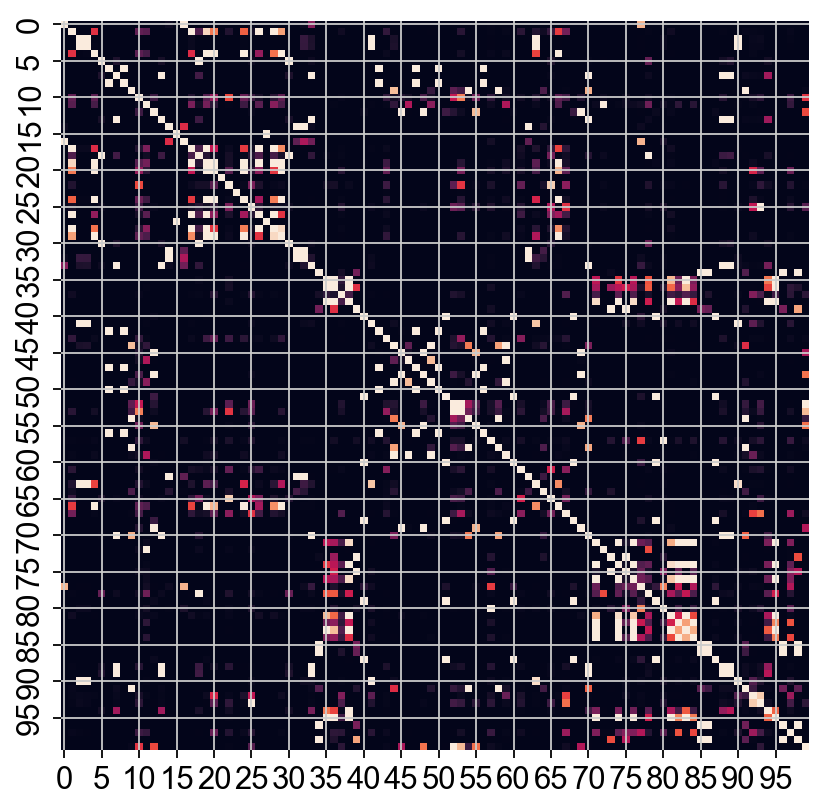

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(norm_cooc_matrix[:100,:100], vmin=0, vmax=0.3, ax=ax, cbar=False)

<Axes: >

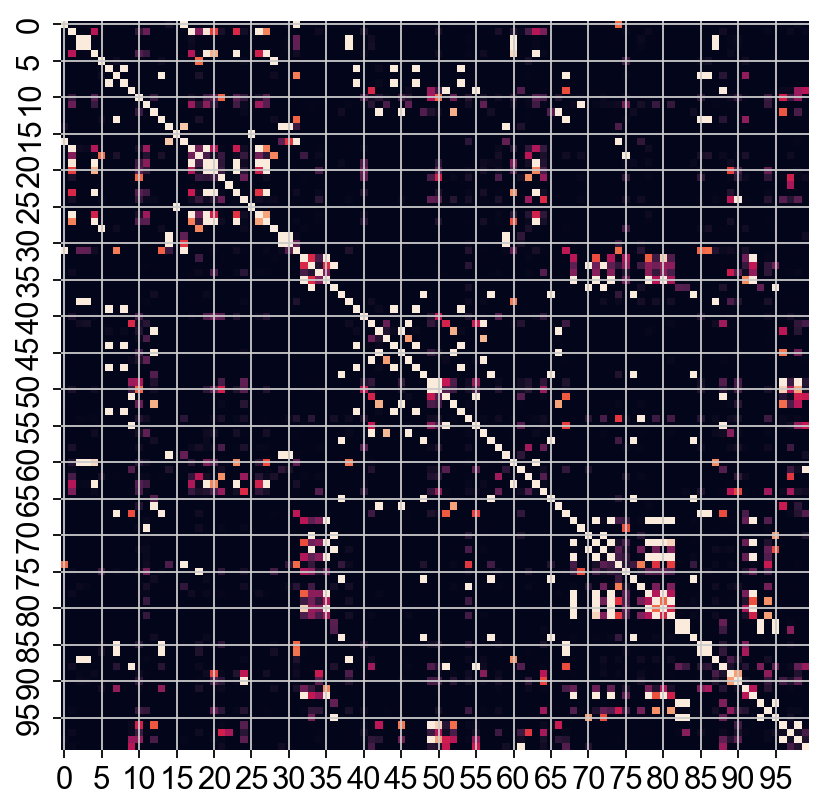

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(norm_cooc_matrix[:100,:100], vmin=0, vmax=0.3, ax=ax, cbar=False)

In [9]:
norm_cooc_matrix = condensed_cooc_matrix_all.reshape([n_cells, n_cells])/len(clustering_summary)
distance_matrix = 1 - norm_cooc_matrix
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix)

list1 = adata_cluster.obs.target_contrast_gene_name_corrected.values
list2 = adata_cluster.obs.culture_condition.values
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
norm_cooc_matrix_df = pd.DataFrame(data=norm_cooc_matrix,
                                   index=ind,
                                   columns=ind)

In [11]:
norm_cooc_matrix_df.to_csv('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor1563resolution24_cooc_matrix.csv')

In [6]:
norm_cooc_matrix_df = pd.read_csv('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor1563resolution24_cooc_matrix.csv', index_col=0)
distance_matrix = 1 - norm_cooc_matrix_df.values
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix_df.values)

In [13]:
norm_cooc_matrix_df

PLAT_Stim8hr  HSPA8_Stim8hr  KLHDC10_Stim8hr  ICOS_Stim8hr  \
PLAT_Stim8hr         0.833333       0.000000         0.000000      0.000000   
HSPA8_Stim8hr        0.000000       0.866667         0.000123      0.000370   
KLHDC10_Stim8hr      0.000000       0.000123         0.876667      0.750988   
ICOS_Stim8hr         0.000000       0.000370         0.750988      0.846667   
ANKRD49_Stim8hr      0.000000       0.170123         0.002099      0.002840   
...                       ...            ...              ...           ...   
SMARCE1_Rest         0.000000       0.009259         0.000000      0.000000   
MYCN_Rest            0.000000       0.000000         0.000000      0.000000   
IRF4_Rest            0.000000       0.000000         0.000000      0.000000   
AASDH_Rest           0.000000       0.000000         0.000000      0.000000   
TM2D1_Rest           0.000000       0.000370         0.209259      0.199753   

                 ANKRD49_Stim8hr  CTU2_Stim8hr  TFAM_Stim48hr  \
PLAT_Stim8hr            0.000000      0.000000            0.0   
HSPA8_Stim8hr           0.170123      0.000741            0.0   
KLHDC10_Stim8hr         0.002099      0.000000            0.0   
ICOS_Stim8hr            0.002840      0.000000            0.0   
ANKRD49_Stim8hr         0.806667      0.000000            0.0   
...                          ...           ...            ...   
SMARCE1_Rest            0.000000      0.000000            0.0   
MYCN_Rest               0.000000      0.005432            0.0   
IRF4_Rest               0.000000      0.000988            0.0   
AASDH_Rest              0.000000      0.000000            0.0   
TM2D1_Rest              0.000000      0.000000            0.0   

                 TMEM131L_Stim48hr  SCO1_Stim48hr  TIMM10_Stim48hr  ...  \
PLAT_Stim8hr              0.000000            0.0          0.00000  ...   
HSPA8_Stim8hr             0.000000            0.0          0.00000  ...   
KLHDC10_Stim8hr           0.000000            0.0          0.00000  ...   
ICOS_Stim8hr              0.000000            0.0          0.00000  ...   
ANKRD49_Stim8hr           0.000000            0.0          0.00000  ...   
...                            ...            ...              ...  ...   
SMARCE1_Rest              0.000617            0.0          0.00358  ...   
MYCN_Rest                 0.000000            0.0          0.00000  ...   
IRF4_Rest                 0.001852            0.0          0.00000  ...   
AASDH_Rest                0.000000            0.0          0.00000  ...   
TM2D1_Rest                0.000370            0.0          0.00000  ...   

                 INSR_Stim8hr  VWF_Stim48hr  RRAGC_Stim48hr  ARL1_Stim48hr  \
PLAT_Stim8hr         0.000000      0.000000             0.0        0.00000   
HSPA8_Stim8hr        0.011975      0.000123             0.0        0.00000   
KLHDC10_Stim8hr      0.000123      0.000000             0.0        0.00000   
ICOS_Stim8hr         0.000247      0.000000             0.0        0.00000   
ANKRD49_Stim8hr      0.000000      0.000000             0.0        0.00000   
...                       ...           ...             ...            ...   
SMARCE1_Rest         0.034691      0.018272             0.0        0.00358   
MYCN_Rest            0.000000      0.000000             0.0        0.00000   
IRF4_Rest            0.000000      0.000000             0.0        0.00000   
AASDH_Rest           0.000000      0.000000             0.0        0.00000   
TM2D1_Rest           0.000000      0.000000             0.0        0.00000   

                 BCL11B_Stim48hr  SMARCE1_Rest  MYCN_Rest  IRF4_Rest  \
PLAT_Stim8hr                 0.0      0.000000   0.000000   0.000000   
HSPA8_Stim8hr                0.0      0.009259   0.000000   0.000000   
KLHDC10_Stim8hr              0.0      0.000000   0.000000   0.000000   
ICOS_Stim8hr                 0.0      0.000000   0.000000   0.000000   
ANKRD49_Stim8hr              0.0      0.000000   0.000000   0.000000   
...              

In [8]:
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=4,
                            min_samples=3,
                            cluster_selection_method='eom')
clusterer.fit(distance_matrix)
final_labels = clusterer.labels_
adata_cluster.obs['hdbscan'] = final_labels
adata_cluster.obs['hdbscan'] = adata_cluster.obs['hdbscan'].astype('category')

In [9]:
adata_cluster.obs['hdbscan'].unique()

[36, 92, 66, 100, 20, ..., 67, 13, 16, 8, 78]
Length: 107
Categories (107, int64): [-1, 0, 1, 2, ..., 102, 103, 104, 105]

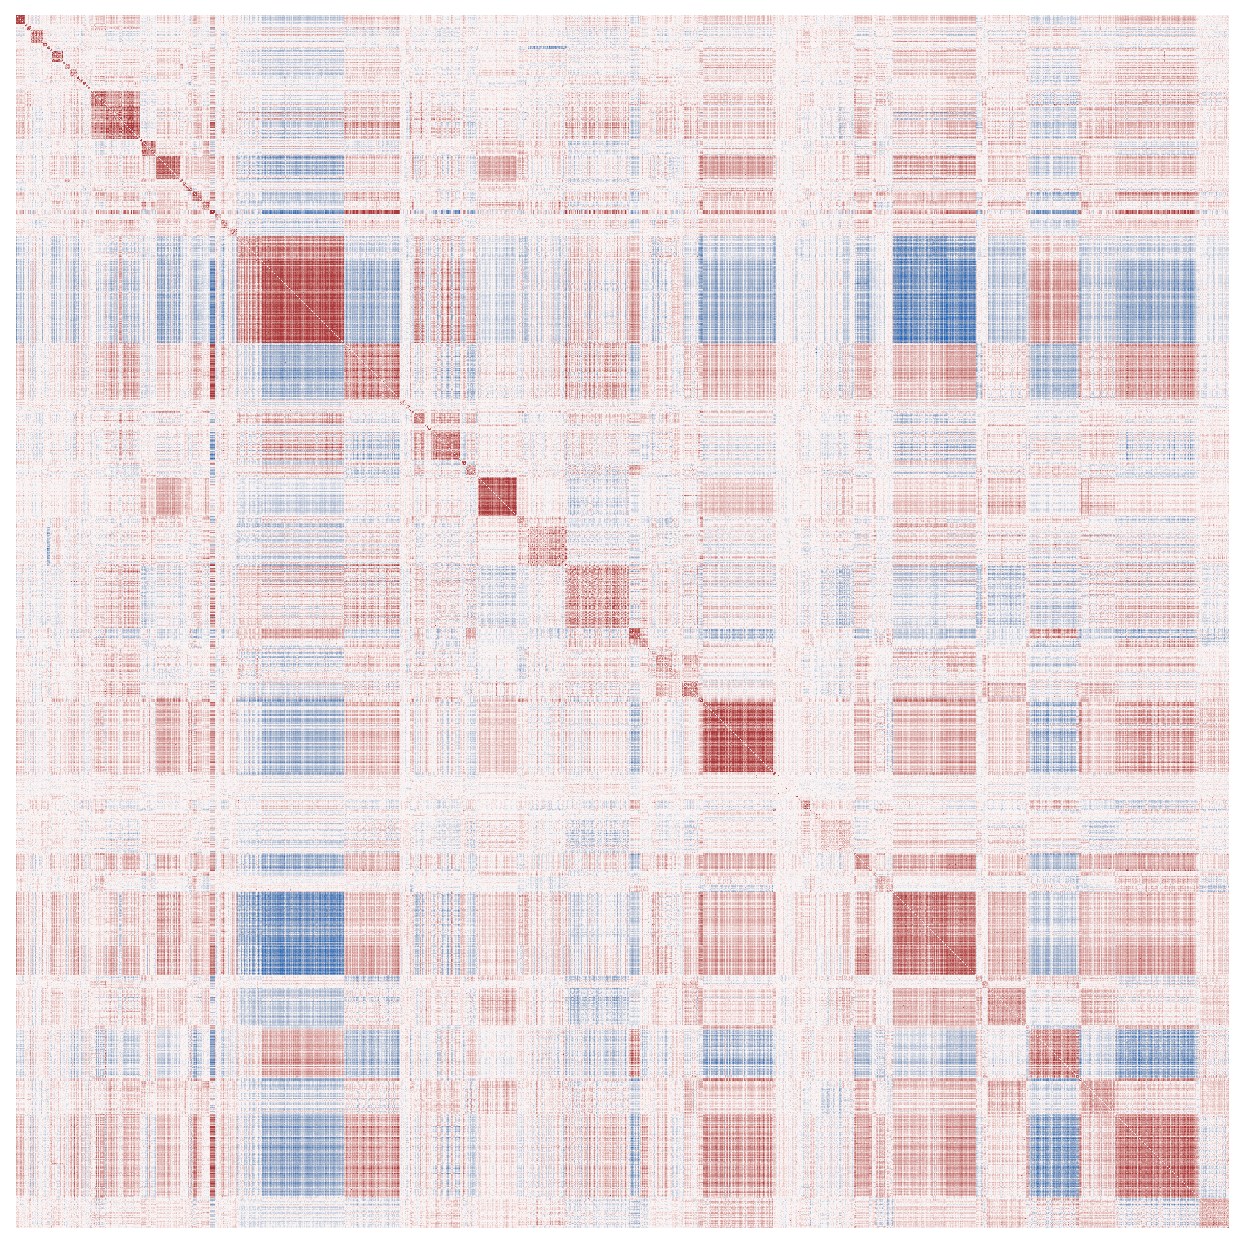

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
cluster_label = 'hdbscan'
j = 0
data = adata_cluster[adata_cluster.obs[cluster_label]==j].layers['zscore']
list1 = adata_cluster[adata_cluster.obs[cluster_label]==j].obs.target_contrast_gene_name_corrected.values.tolist()
list2 = adata_cluster[adata_cluster.obs[cluster_label]==j].obs.culture_condition.values.tolist()
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
for i in range(j,104):
    data = np.concatenate([data, adata_cluster[adata_cluster.obs[cluster_label]==i+1].layers['zscore']])
    list1 = adata_cluster[adata_cluster.obs[cluster_label]==i+1].obs.target_contrast_gene_name.values.tolist()
    list2 = adata_cluster[adata_cluster.obs[cluster_label]==i+1].obs.culture_condition.values.tolist()
    ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
test = pd.DataFrame(data=data,
                    index=ind,
                    columns=adata_cluster.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, vmin=-0.5, vmax=0.5, xticklabels=False, yticklabels=False, cmap='vlag', cbar=False, ax=ax)
plt.tight_layout()

### Filter out low quality hdbscan clusters

In [55]:
np.max(adata_cluster.obs['hdbscan'].astype(int))

105

In [56]:
num_of_cluster = np.max(adata_cluster.obs['hdbscan'].astype(int))+1
corr = np.zeros(num_of_cluster)
cluster_size = np.zeros(num_of_cluster)
cluster_gene_size = np.zeros(num_of_cluster)
cluster_member = []
for i in range(len(corr)):
    list1 = adata_cluster[adata_cluster.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata_cluster[adata_cluster.obs['hdbscan']==i].obs.culture_condition.values.tolist()
    test = pd.DataFrame(data=adata_cluster[adata_cluster.obs['hdbscan']==i].layers['zscore'],
                        index=[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)],
                        columns=adata_cluster.var.gene_name)
    test2 = test.T.corr()
    np.fill_diagonal(test2.values, 0)
    corr[i] = np.mean(test2)
    cluster_size[i] = len(test)
    cluster_gene_size[i] = len(adata_cluster[adata_cluster.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.unique())
    cluster_member.append(adata_cluster[adata_cluster.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.unique().tolist())

cluster_df = pd.DataFrame({'cluster': np.arange(0, num_of_cluster, 1),
                           'intracluster_corr': corr,
                           'cluster_size': cluster_size,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

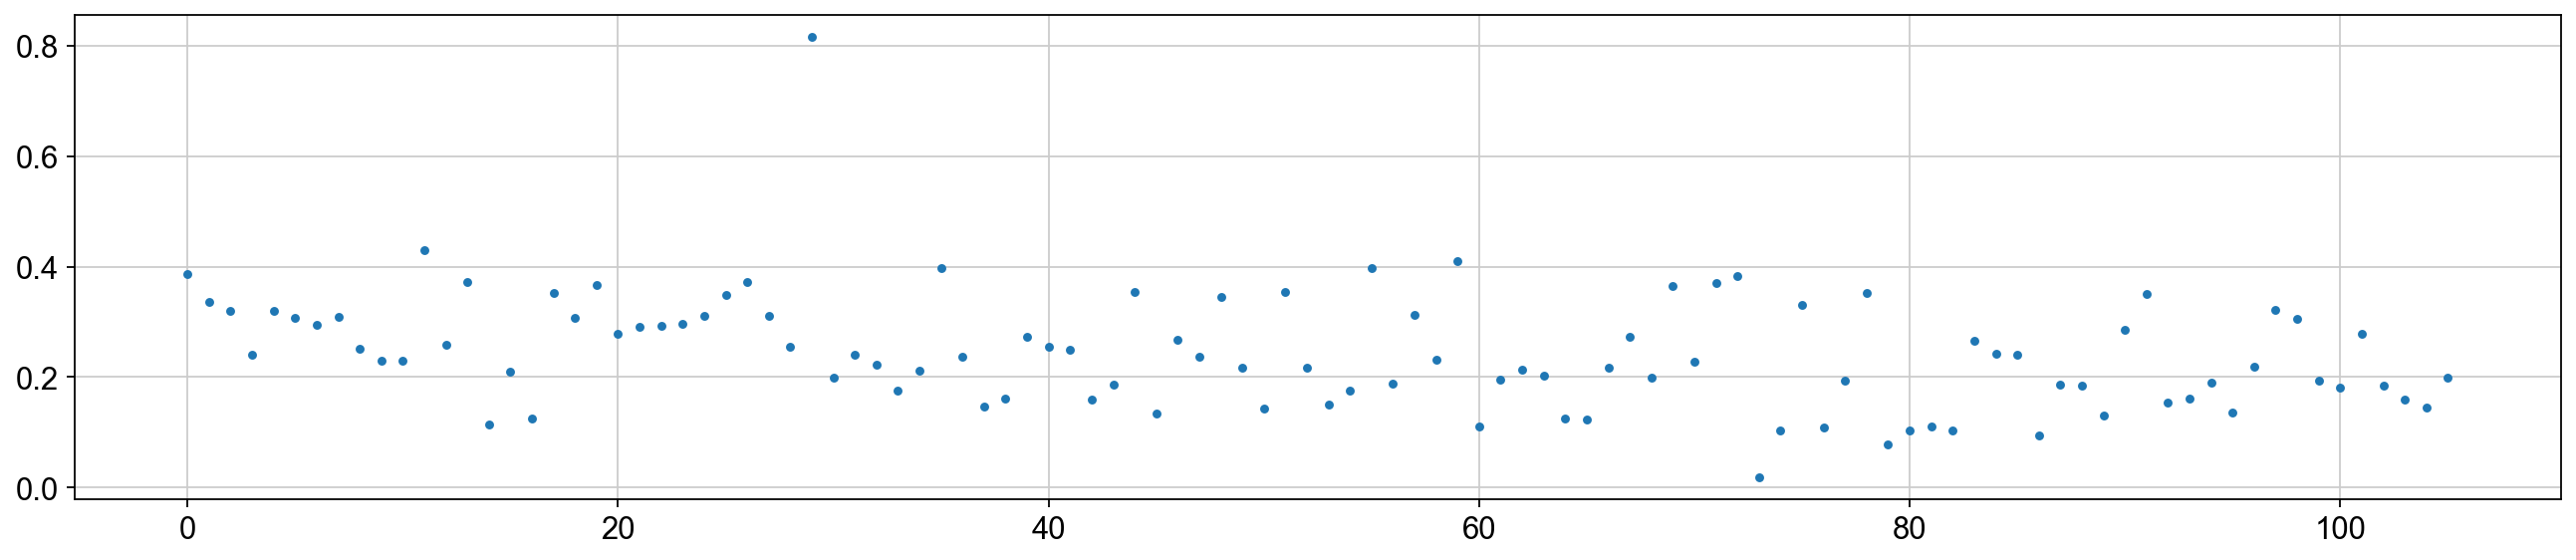

In [57]:
plt.plot(cluster_df.intracluster_corr, '.')

In [58]:
adata_final = adata_cluster.copy()
adata_final.obs.loc[adata_final.obs['hdbscan'].isin(np.where(cluster_df.intracluster_corr<0.2)[0]), 'hdbscan'] = -1
adata_final.obs.loc[adata_final.obs['hdbscan'].isin(np.where(cluster_gene_size<3)[0]), 'hdbscan'] = -1
adata_final.obs['hdbscan'] = adata_final.obs['hdbscan'].astype('category')
adata_final = adata_final[adata_final.obs.hdbscan!=-1].copy()

In [60]:
len(adata_final.obs['hdbscan'].unique())

55

In [61]:
adata_final.obs.target_contrast_gene_name.unique()

['PLAT', 'KLHDC10', 'ICOS', 'CTU2', 'TFAM', ..., 'TYK2', 'TRMT6', 'VWF', 'ARL1', 'BCL11B']
Length: 1354
Categories (1354, object): ['A2M', 'AASDH', 'ABCA3', 'ABCC1', ..., 'ZSCAN25', 'ZSWIM4', 'ZSWIM9', 'ZW10']

### Run gene set enrichment analysis

In [62]:
import gseapy
from gseapy import Msigdb
from gseapy import barplot, dotplot

msig = Msigdb()
kegg_gene_sets = msig.get_gmt(category= 'c2.cp.kegg_legacy', dbver="2025.1.Hs")
reactome_gene_sets = msig.get_gmt(category= 'c2.cp.reactome', dbver="2025.1.Hs")

In [63]:
corum_df = pd.read_csv('../../../RZAnalysisCodes/results/CORUM/corum_humanComplexes.txt', delimiter='\t', index_col='complex_id')
stringdb = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.clusters.proteins.v12.0.txt.gz', delimiter='\t', compression='gzip')
protein_info = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.protein.info.v12.0.txt.gz', delimiter='\t', compression='gzip')
cluster_info = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.clusters.info.v12.0.txt.gz', delimiter='\t', compression='gzip')
stringdb_df = pd.merge(stringdb, protein_info, left_on='protein_id', right_on='#string_protein_id')
stringdb_df = pd.merge(stringdb_df, cluster_info, left_on='cluster_id', right_on='cluster_id')
stringdb_df = stringdb_df[stringdb_df.cluster_size<1000].copy()

corum_complexes = {}
for _, row in corum_df.iterrows():
    complex_name = row['complex_name']
    subunits = set(row['subunits_gene_name'].split(';'))
    corum_complexes[complex_name] = subunits

stringdb_complexes = {}
for cluster_id in stringdb_df.cluster_id.unique():
    stringdb_complexes[cluster_id] = set(stringdb_df[stringdb_df.cluster_id==cluster_id].preferred_name)

In [64]:
def assess_complex_enrichment(adata, complexes, cluster_label):
    """
    Assess pathway/complex enrichment
    """
    de_genes_per_cluster = {}
    leiden_clusters = adata.obs[cluster_label].unique()
    for cluster in leiden_clusters:
        cluster_genes = adata[adata.obs[cluster_label] == cluster].obs.target_contrast_gene_name_corrected
        de_genes_per_cluster[cluster] = set(cluster_genes)
    
    N = len(adata)
    
    best_result = []
    all_result = []
    for cluster, de_genes in de_genes_per_cluster.items():
        n = len(de_genes)
        best_result_for_cluster = None # Initialize a variable to track the best result for this cluster
        for complex_name, subunits in complexes.items():
            K = len(subunits)
            # Find the overlap between DE genes and complex subunits
            overlap = de_genes.intersection(subunits)
            k = len(overlap)
            
            # Calculate the p-value
            if n > 0 and K > 0: # Avoid division by zero or trivial cases
                pval = hypergeom.sf(k - 1, N, K, n) # sf is survival function
                
                # Adjust for multiple testing (e.g., using Benjamini-Hochberg)
                # This is a crucial step to avoid false positives
                # Store raw p-values and correct later
                current_result = {
                    'cluster': cluster,
                    'complex': complex_name,
                    'overlap_genes': list(overlap),
                    'overlap_fraction': len(overlap)/n,
                    'raw_p_value': pval,
                    'complex_size': K
                }
                
                if (best_result_for_cluster is None) or (pval < best_result_for_cluster['raw_p_value']):
                    best_result_for_cluster = current_result
                if pval < 5e-2:
                    all_result.append(current_result)
        
        if best_result_for_cluster is not None:
            if best_result_for_cluster['raw_p_value']<1:
                best_result.append(best_result_for_cluster)
    
    # Convert results to a DataFrame for easy viewing
    best_result_df = pd.DataFrame(best_result)
    best_result_df = best_result_df.sort_values(by='cluster').reset_index(drop=True)
    all_result_df = pd.DataFrame(all_result)
    all_result_df = all_result_df.sort_values(by='cluster').reset_index(drop=True)

    return all_result_df, best_result_df

In [65]:
# STRINGDB enrichment
stringdb_enrichment_all, stringdb_enrichment_best = assess_complex_enrichment(adata_final, stringdb_complexes, 'hdbscan')
stringdb_enrichment_all = pd.merge(stringdb_enrichment_all, stringdb_df[['cluster_id', 'best_described_by']].drop_duplicates(), left_on='complex', right_on='cluster_id')
stringdb_enrichment_all = stringdb_enrichment_all.drop(columns=['cluster_id'])
stringdb_enrichment_best = pd.merge(stringdb_enrichment_best, stringdb_df[['cluster_id', 'best_described_by']].drop_duplicates(), left_on='complex', right_on='cluster_id')
stringdb_enrichment_best = stringdb_enrichment_best.drop(columns=['cluster_id'])
# Corum enrichment
corum_enrichment_all, corum_enrichment_best = assess_complex_enrichment(adata_final, corum_complexes, 'hdbscan')
# KEGG enrichment
kegg_enrichment_all, kegg_enrichment_best = assess_complex_enrichment(adata_final, kegg_gene_sets, 'hdbscan')
# Reactome enrichment
reactome_enrichment_all, reactome_enrichment_best = assess_complex_enrichment(adata_final, reactome_gene_sets, 'hdbscan')

# Also checking inter-cluster overlap
gene_grouping = {}
for cluster in adata_final.obs.hdbscan.unique():
    gene_grouping[cluster] = set(adata_final[adata_final.obs['hdbscan']==cluster].obs.target_contrast_gene_name_corrected)

intercluster_enrichment_all, _ = assess_complex_enrichment(adata_final, gene_grouping, 'hdbscan')
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.cluster!=intercluster_enrichment_all.complex].copy()
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.raw_p_value<1e-2].copy()
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.overlap_fraction>=0.2].copy()
intercluster_enrichment_summary = {}

for cluster in intercluster_enrichment_all.cluster.unique():
    intercluster_enrichment_summary[cluster] = set(intercluster_enrichment_all[intercluster_enrichment_all.cluster==cluster].complex)

intercluster_enrichment_summary_df = pd.DataFrame(intercluster_enrichment_summary.items(), columns=['cluster', 'related_cluster'])

# Summarize results
enrichment_df1 = pd.merge(corum_enrichment_best, stringdb_enrichment_best, on='cluster', how='outer', suffixes=('_corum', '_stringdb'))
enrichment_df2 = pd.merge(kegg_enrichment_best, reactome_enrichment_best, on='cluster', how='outer', suffixes=('_kegg', '_reactome'))
enrichment_df = pd.merge(enrichment_df1, enrichment_df2, on='cluster', how='outer')
enrichment_df = pd.merge(enrichment_df, cluster_df, on='cluster', how='inner')
enrichment_df = pd.merge(enrichment_df, intercluster_enrichment_summary_df, on='cluster', how='outer')

# Add timepoint information
cluster_member_with_condition = []
for index, row in enrichment_df.iterrows():
    list1 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.target_contrast_gene_name_corrected.tolist()
    list2 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.culture_condition.tolist()
    cluster_member_with_condition.append([f"{item1}_{item2}" for item1, item2 in zip(list1, list2)])
    enrichment_df.loc[index, 'rest_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Rest')])
    enrichment_df.loc[index, 'stim8hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim8hr')])
    enrichment_df.loc[index, 'stim48hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim48hr')])
    
enrichment_df['cluster_member_with_condition'] = cluster_member_with_condition

In [66]:
enrichment_df.to_parquet('results/clustering_nde50ntotal100.parquet')
enrichment_df.to_csv('results/clustering_nde50ntotal100.csv')
corum_enrichment_all.to_parquet('results/corum_enrichment_nde50ntotal100.parquet')
corum_enrichment_all.to_csv('results/corum_enrichment_nde50ntotal100.csv')
stringdb_enrichment_all.to_parquet('results/stringdb_enrichment_nde50ntotal100.parquet')
stringdb_enrichment_all.to_csv('results/stringdb_enrichment_nde50ntotal100.csv')
kegg_enrichment_all.to_parquet('results/kegg_enrichment_nde50ntotal100.parquet')
kegg_enrichment_all.to_csv('results/kegg_enrichment_nde50ntotal100.csv')
reactome_enrichment_all.to_parquet('results/reactome_enrichment_nde50ntotal100.parquet')
reactome_enrichment_all.to_csv('results/reactome_enrichment_nde50ntotal100.csv')

In [67]:
adata_final.write_h5ad('../../../RZAnalysisCodes/results/nde50ntotal100_varfiltered_clustering.h5ad')

In [14]:
adata_final = sc.read_h5ad('../../../RZAnalysisCodes/results/nde50ntotal100_varfiltered_clustering.h5ad')

In [16]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name_corrected.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

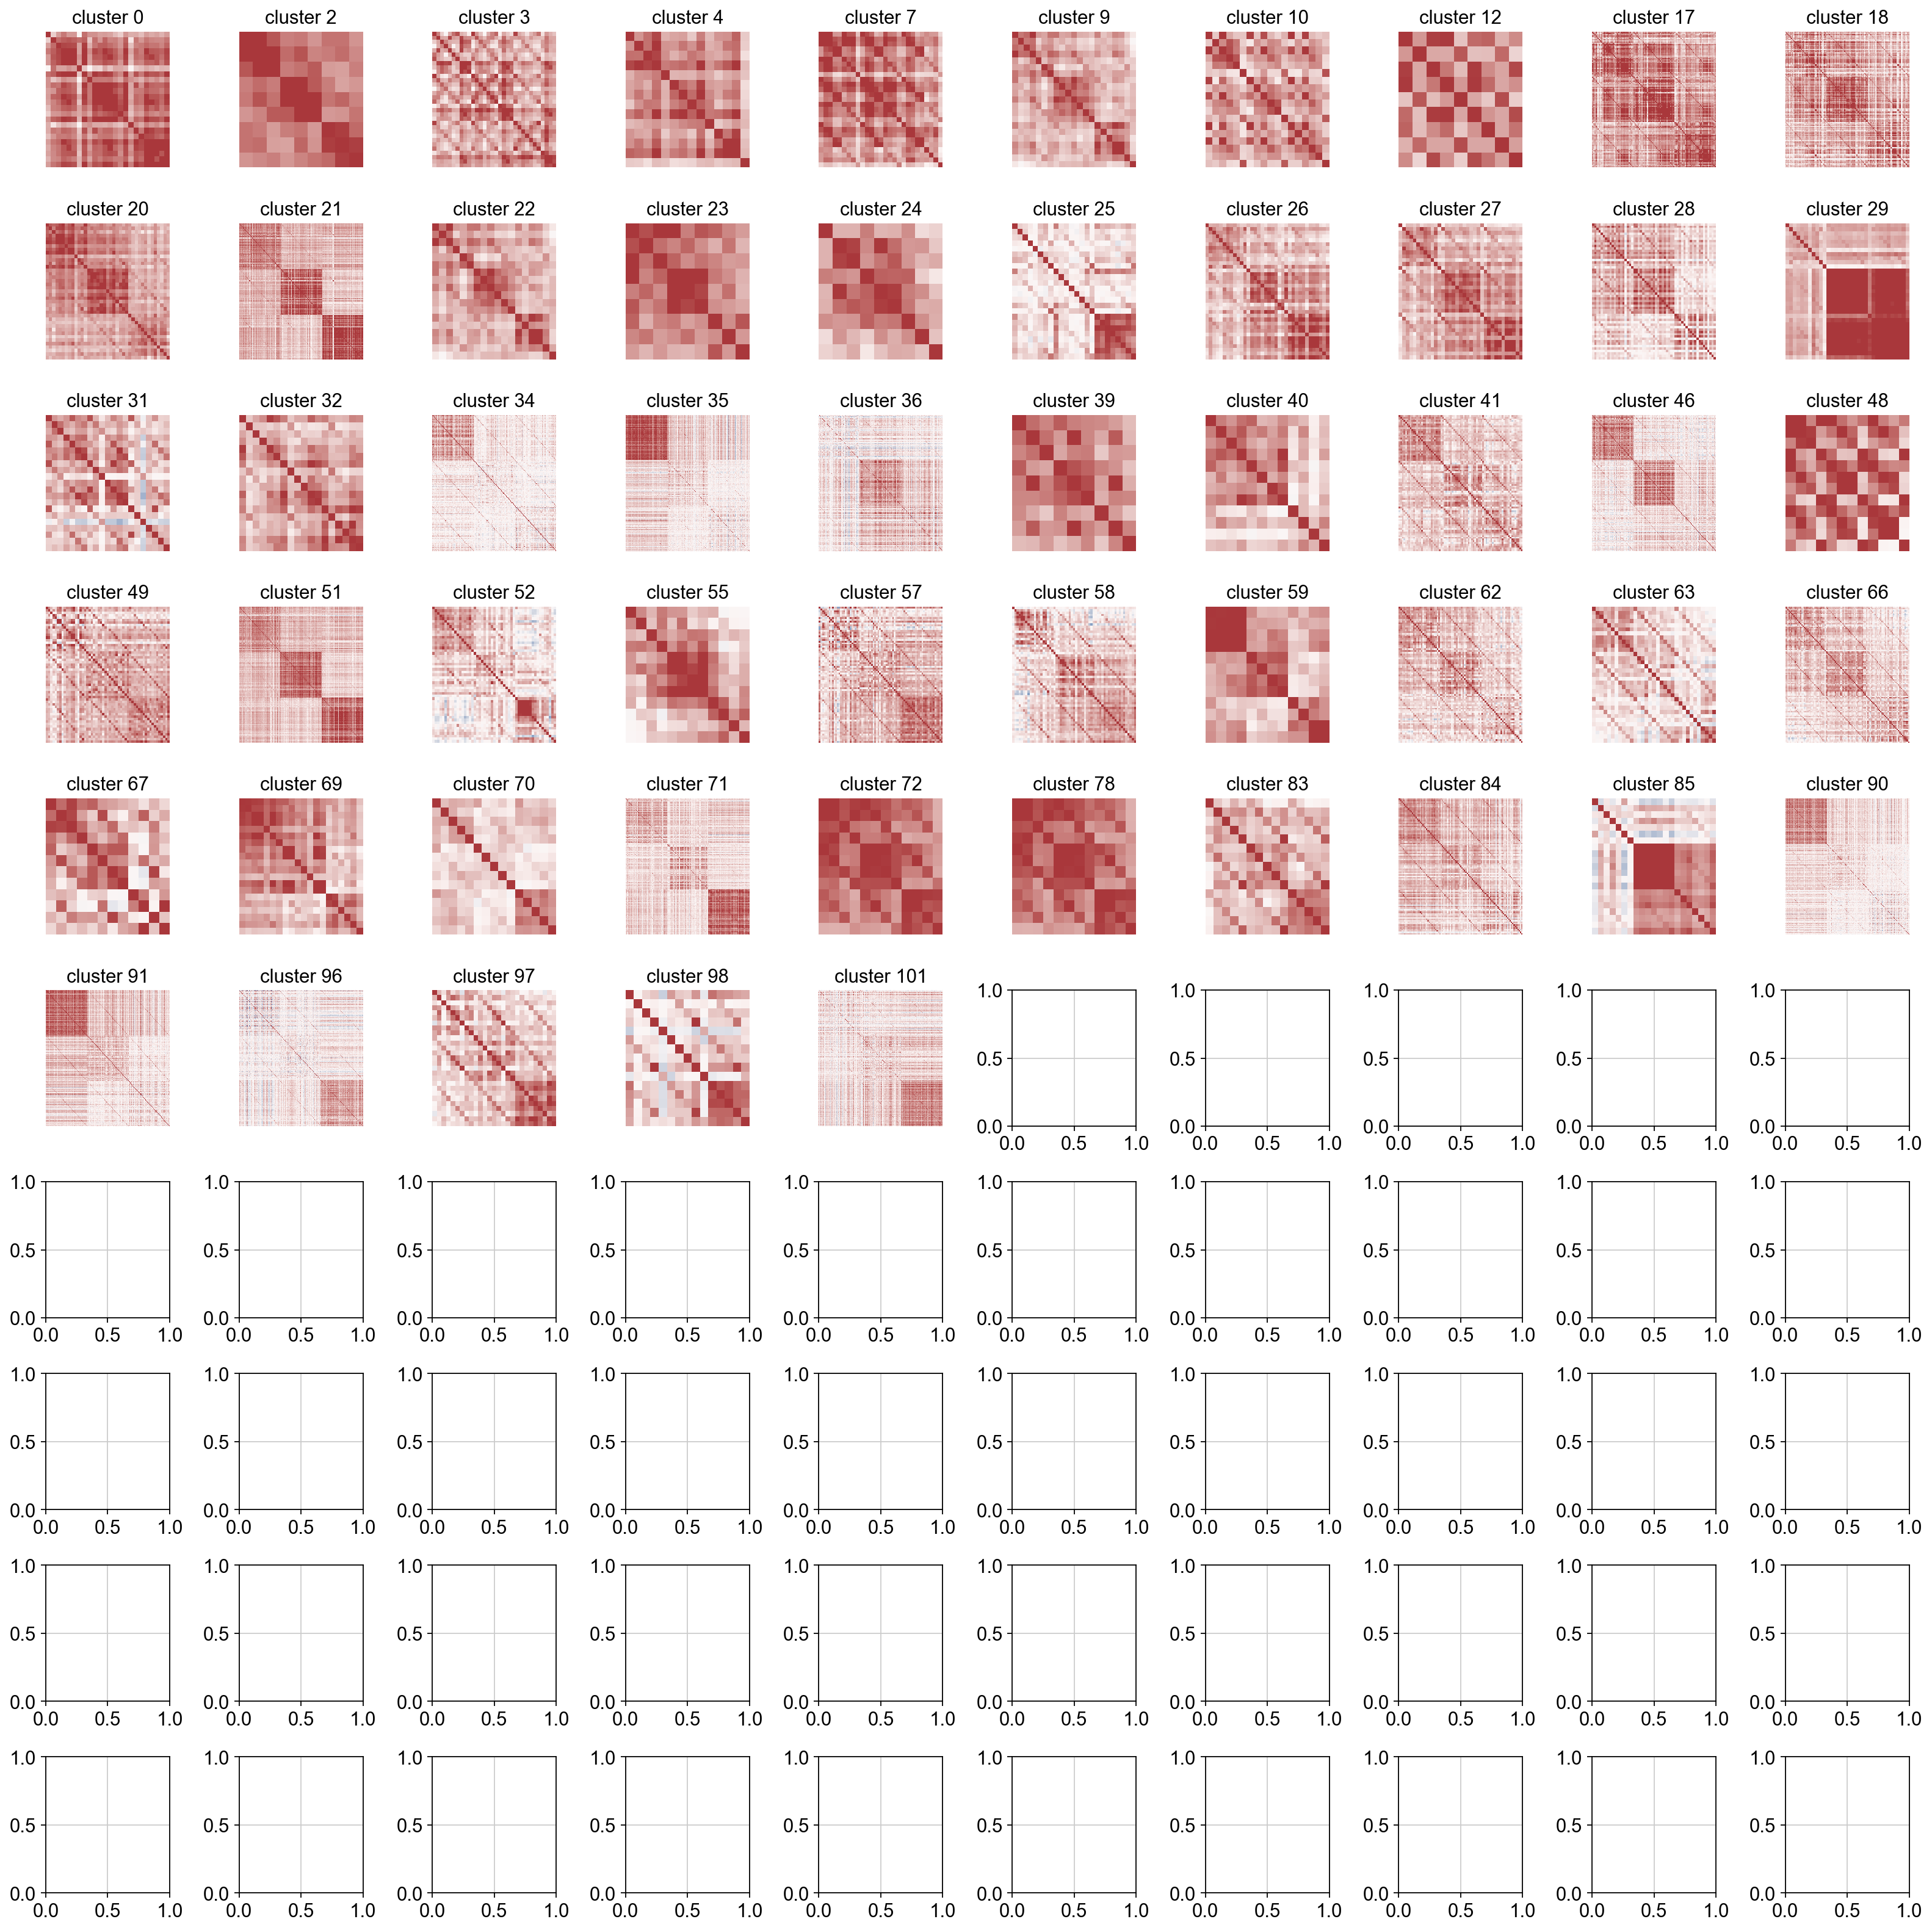

In [69]:
fig, axes = plt.subplots(10,10,figsize=(20,20))
ax = axes.flatten()
cluster_list = np.sort(adata_final.obs.hdbscan.unique())
for i in range(55):
    genelist = adata_final[adata_final.obs.hdbscan==cluster_list[i]].obs.target_contrast_gene_name_corrected.unique().tolist()
    corr_mtx = corr_compute(adata_de, genelist)
    sns.heatmap(corr_mtx, vmin=-0.5, vmax=0.5, cmap='vlag', ax=ax[i], xticklabels=[], yticklabels=[], cbar=False)
    ax[i].set_title('cluster '+str(cluster_list[i]))
plt.tight_layout()

In [70]:
adata_final[adata_final.obs.target_contrast_gene_name.str.startswith('MRPL')]

View of AnnData object with n_obs × n_vars = 41 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [107]:
adata_final[adata_final.obs.hdbscan==78].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000181090_Stim48hr                     EHMT1          Stim48hr   
ENSG00000204371_Stim48hr                     EHMT2          Stim48hr   
ENSG00000011451_Stim48hr                       WIZ          Stim48hr   
ENSG00000122482_Stim48hr                    ZNF644          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000181090_Stim48hr  ENSG00000181090   438          1626.0   
ENSG00000204371_Stim48hr  ENSG00000204371   324           629.0   
ENSG00000011451_Stim48hr  ENSG00000011451   504          1115.0   
ENSG00000122482_Stim48hr  ENSG00000122482   414           591.0   

                         target_contrast_corrected  \
ENSG00000181090_Stim48hr           ENSG00000181090   
ENSG00000204371_Stim48hr           ENSG00000204371   
ENSG00000011451_Stim48hr           ENSG00000011451   
ENSG00000122482_Stim48hr           ENSG00000122482   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000181090_Stim48hr                               EHMT1      78  
ENSG00000204371_Stim48hr                               EHMT2      78  
ENSG00000011451_Stim48hr                                 WIZ      78  
ENSG00000122482_Stim48hr                              ZNF644      78

In [104]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected.str.startswith('LCK')].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000182866_Stim8hr                        LCK           Stim8hr   
ENSG00000182866_Stim48hr                       LCK          Stim48hr   
ENSG00000182866_Rest                           LCK              Rest   

                          target_contrast chunk  n_cells_target  \
ENSG00000182866_Stim8hr   ENSG00000182866    59           116.0   
ENSG00000182866_Stim48hr  ENSG00000182866   432           107.0   
ENSG00000182866_Rest      ENSG00000182866   459           102.0   

                         target_contrast_corrected  \
ENSG00000182866_Stim8hr            ENSG00000182866   
ENSG00000182866_Stim48hr           ENSG00000182866   
ENSG00000182866_Rest               ENSG00000182866   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000182866_Stim8hr                                  LCK      36  
ENSG00000182866_Stim48hr                                 LCK     101  
ENSG00000182866_Rest                                     LCK      90

target_contrast target_name condition  n_cells_target  n_up_genes  \
2370   ENSG00000128683        GAD1  Stim48hr           733.0           0   
12462  ENSG00000128683        GAD1   Stim8hr           673.0           1   
31086  ENSG00000128683        GAD1      Rest           723.0           2   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
2370              1                 1             -6.418918   
12462             1                 2             -4.389556   
31086             0                 2             -2.358590   

       ontarget_significant  baseMean  offtarget_flag n_total_genes_category  \
2370                   True  9.808407           False              1 DE gene   
12462                  True  4.670098           False          2-10 DE genes   
31086                 False  1.034175           False          2-10 DE genes   

      ontarget_effect_category target_contrast_corrected  \
2370              on-target KD           ENSG00000128683   
12462             on-target KD           ENSG00000128683   
31086          no on-target KD           ENSG00000128683   

                      obs_names target_name_corrected  
2370   ENSG00000128683_Stim48hr                  GAD1  
12462   ENSG00000128683_Stim8hr                  GAD1  
31086      ENSG00000128683_Rest                  GAD1

In [98]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name=='ITK'].obs

target_contrast_gene_name culture_condition  \
ENSG00000113263_Stim8hr                        ITK           Stim8hr   
ENSG00000113263_Stim48hr                       ITK          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000113263_Stim8hr   ENSG00000113263   443           517.0   
ENSG00000113263_Stim48hr  ENSG00000113263   610           361.0   

                         target_contrast_corrected  \
ENSG00000113263_Stim8hr            ENSG00000113263   
ENSG00000113263_Stim48hr           ENSG00000113263   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000113263_Stim8hr                                  ITK      36  
ENSG00000113263_Stim48hr                                 ITK     101

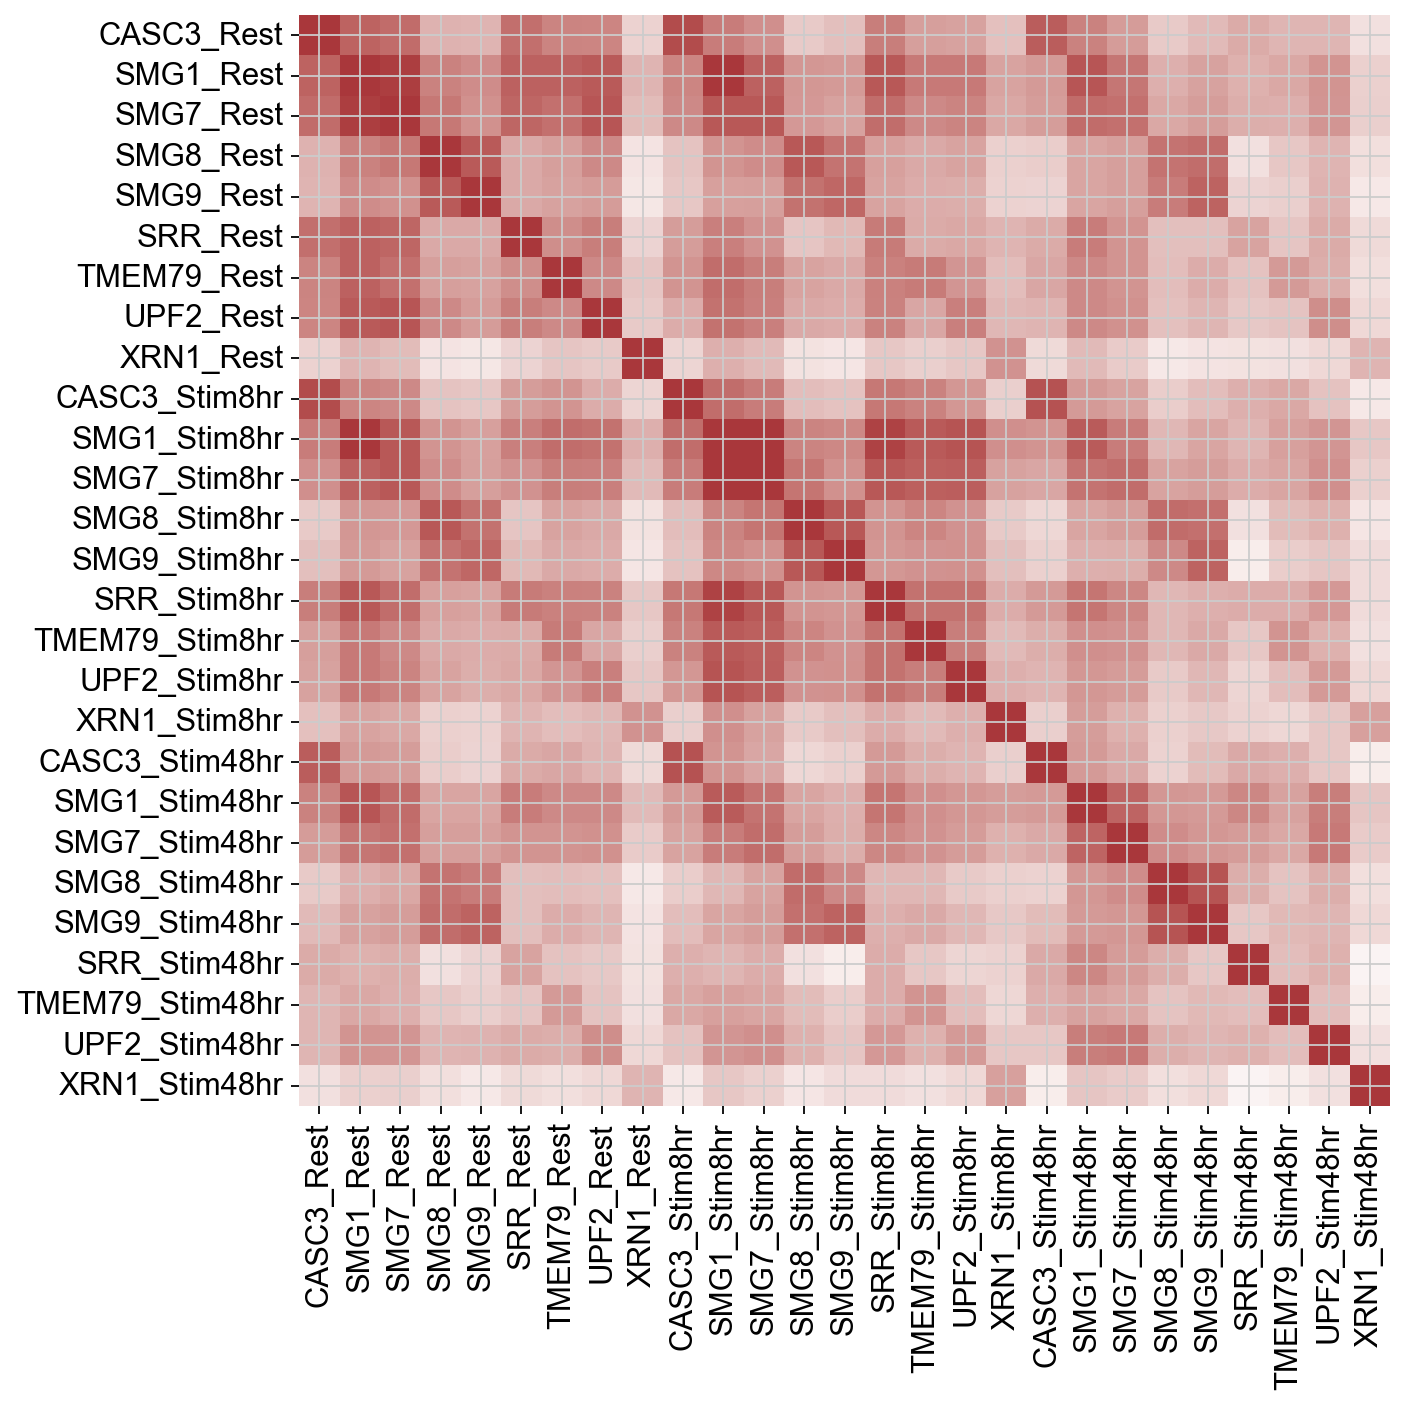

In [115]:
plt.figure(figsize=(9, 9))
genelist = adata_final[adata_final.obs.hdbscan==7].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster7.png')

In [22]:
len(genelist)

195

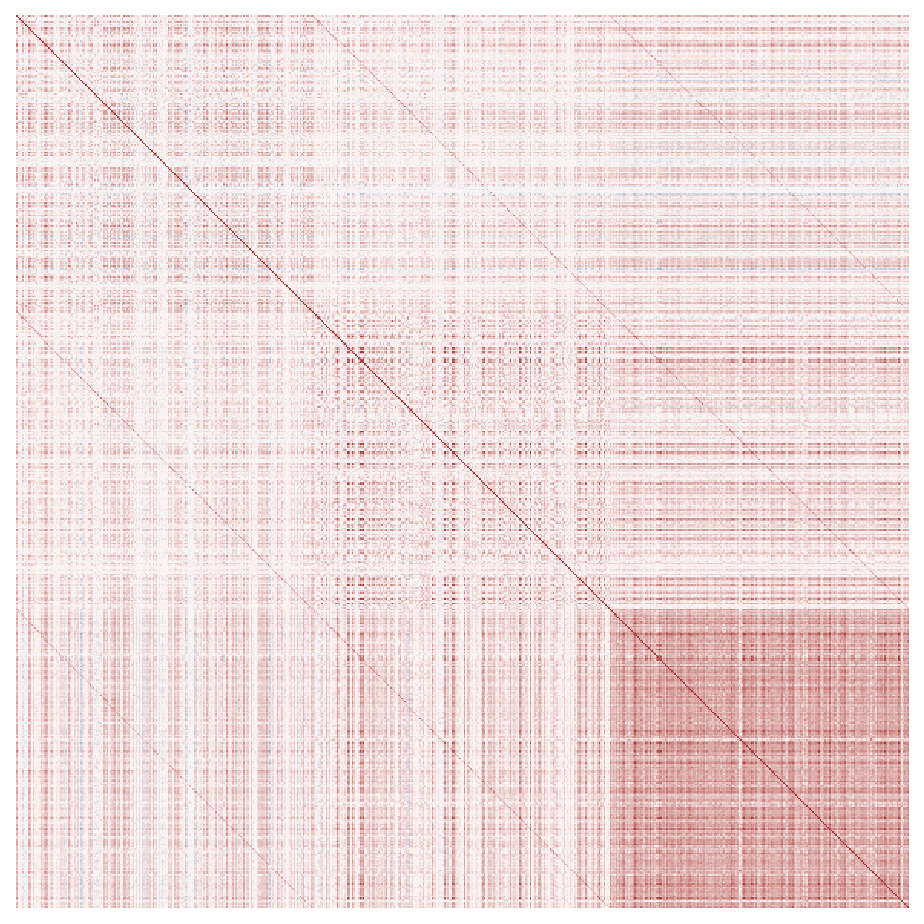

In [18]:
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==101].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False, xticklabels=False, yticklabels=False)
plt.tight_layout()
plt.savefig('results/cluster101.png')

In [89]:
adata_final[adata_final.obs.hdbscan==25].obs.target_contrast_gene_name_corrected.unique().tolist()

['SLC25A1', 'PDHB', 'MDH2', 'DLAT', 'PDHA1', 'CS', 'ACLY', 'STYXL1']

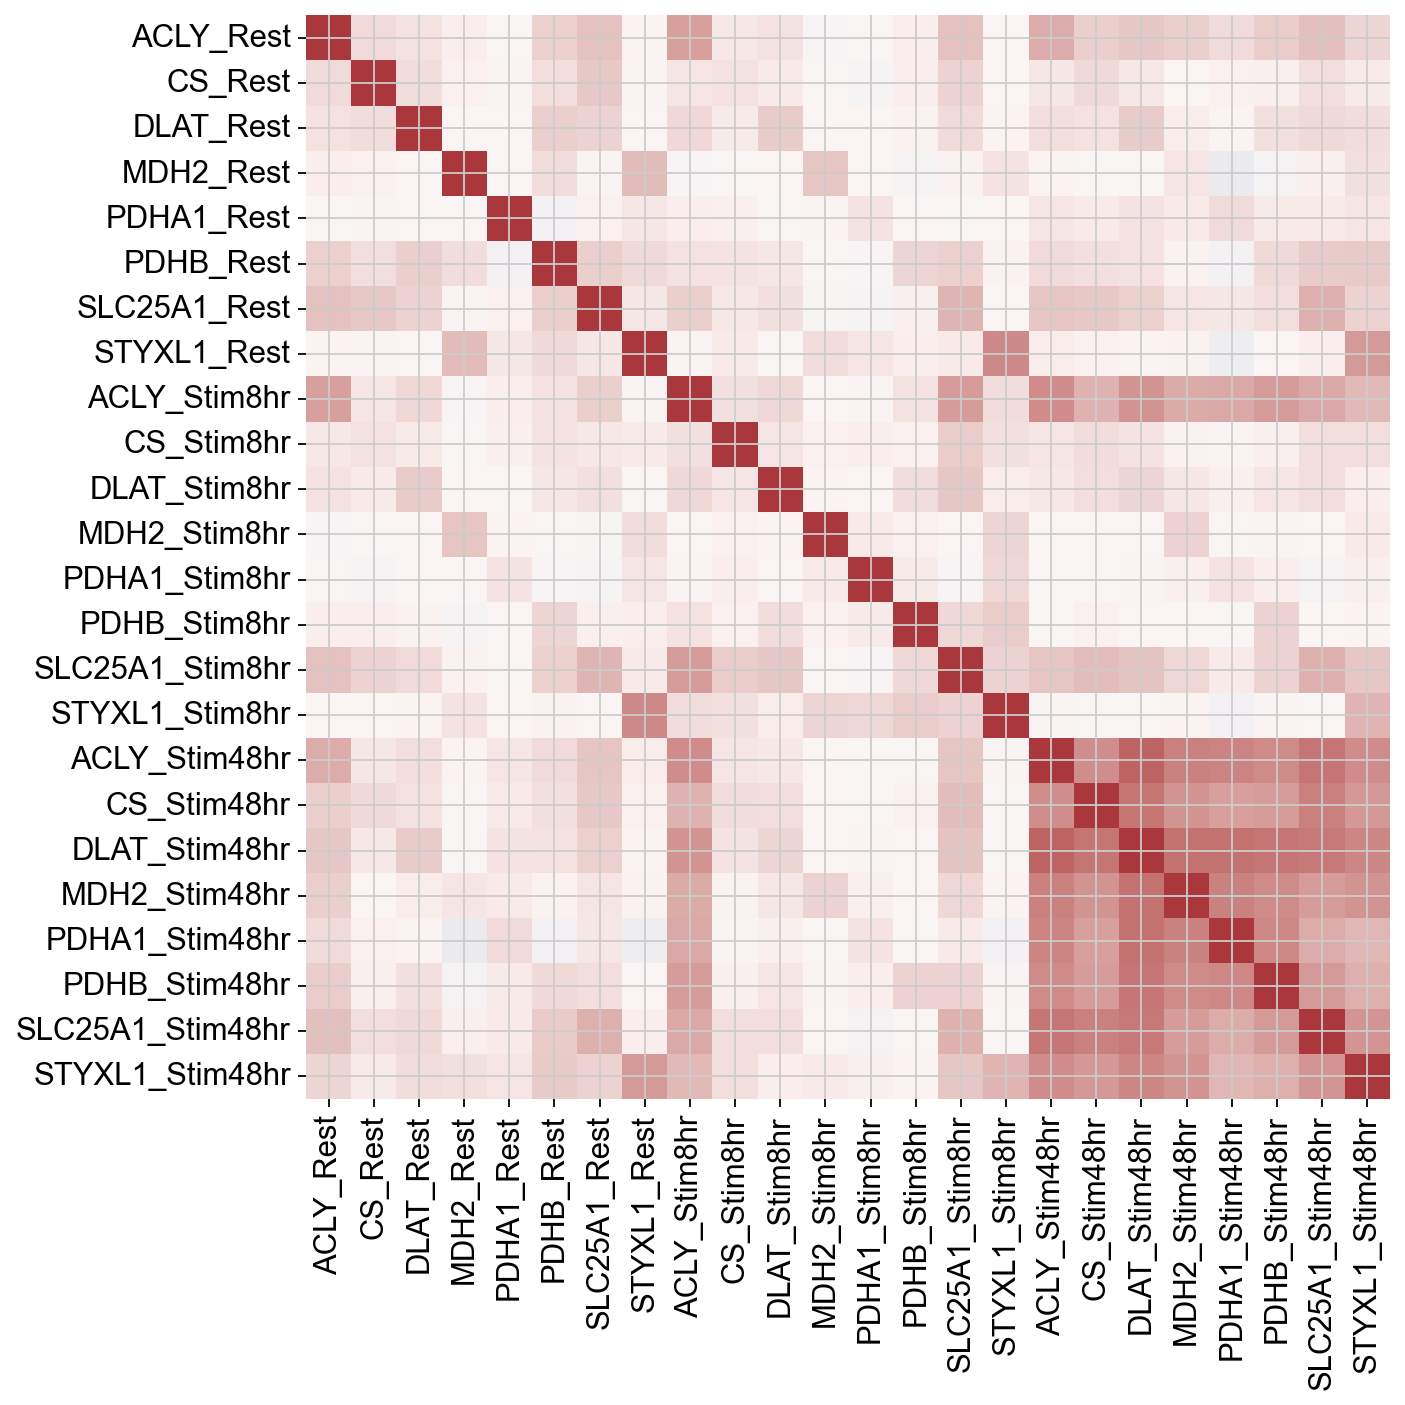

In [85]:
plt.figure(figsize=(9, 9))
genelist = adata_final[adata_final.obs.hdbscan==25].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster25.png')

In [103]:
de_summary_stats[de_summary_stats.target_name=='LCK']

target_contrast target_name condition  n_cells_target  n_up_genes  \
2984   ENSG00000182866         LCK   Stim8hr           116.0        1745   
21628  ENSG00000182866         LCK  Stim48hr           107.0         613   
22978  ENSG00000182866         LCK      Rest           102.0         103   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
2984            669              2414             -8.989515   
21628           303               916             -9.689431   
22978           206               309            -10.907615   

       ontarget_significant    baseMean  offtarget_flag  \
2984                   True  129.013733           False   
21628                  True  160.513650           False   
22978                  True  205.543259           False   

      n_total_genes_category ontarget_effect_category  \
2984            >10 DE genes             on-target KD   
21628           >10 DE genes             on-target KD   
22978           >10 DE genes             on-target KD   

      target_contrast_corrected                 obs_names  \
2984            ENSG00000182866   ENSG00000182866_Stim8hr   
21628           ENSG00000182866  ENSG00000182866_Stim48hr   
22978           ENSG00000182866      ENSG00000182866_Rest   

      target_name_corrected  
2984                    LCK  
21628                   LCK  
22978                   LCK

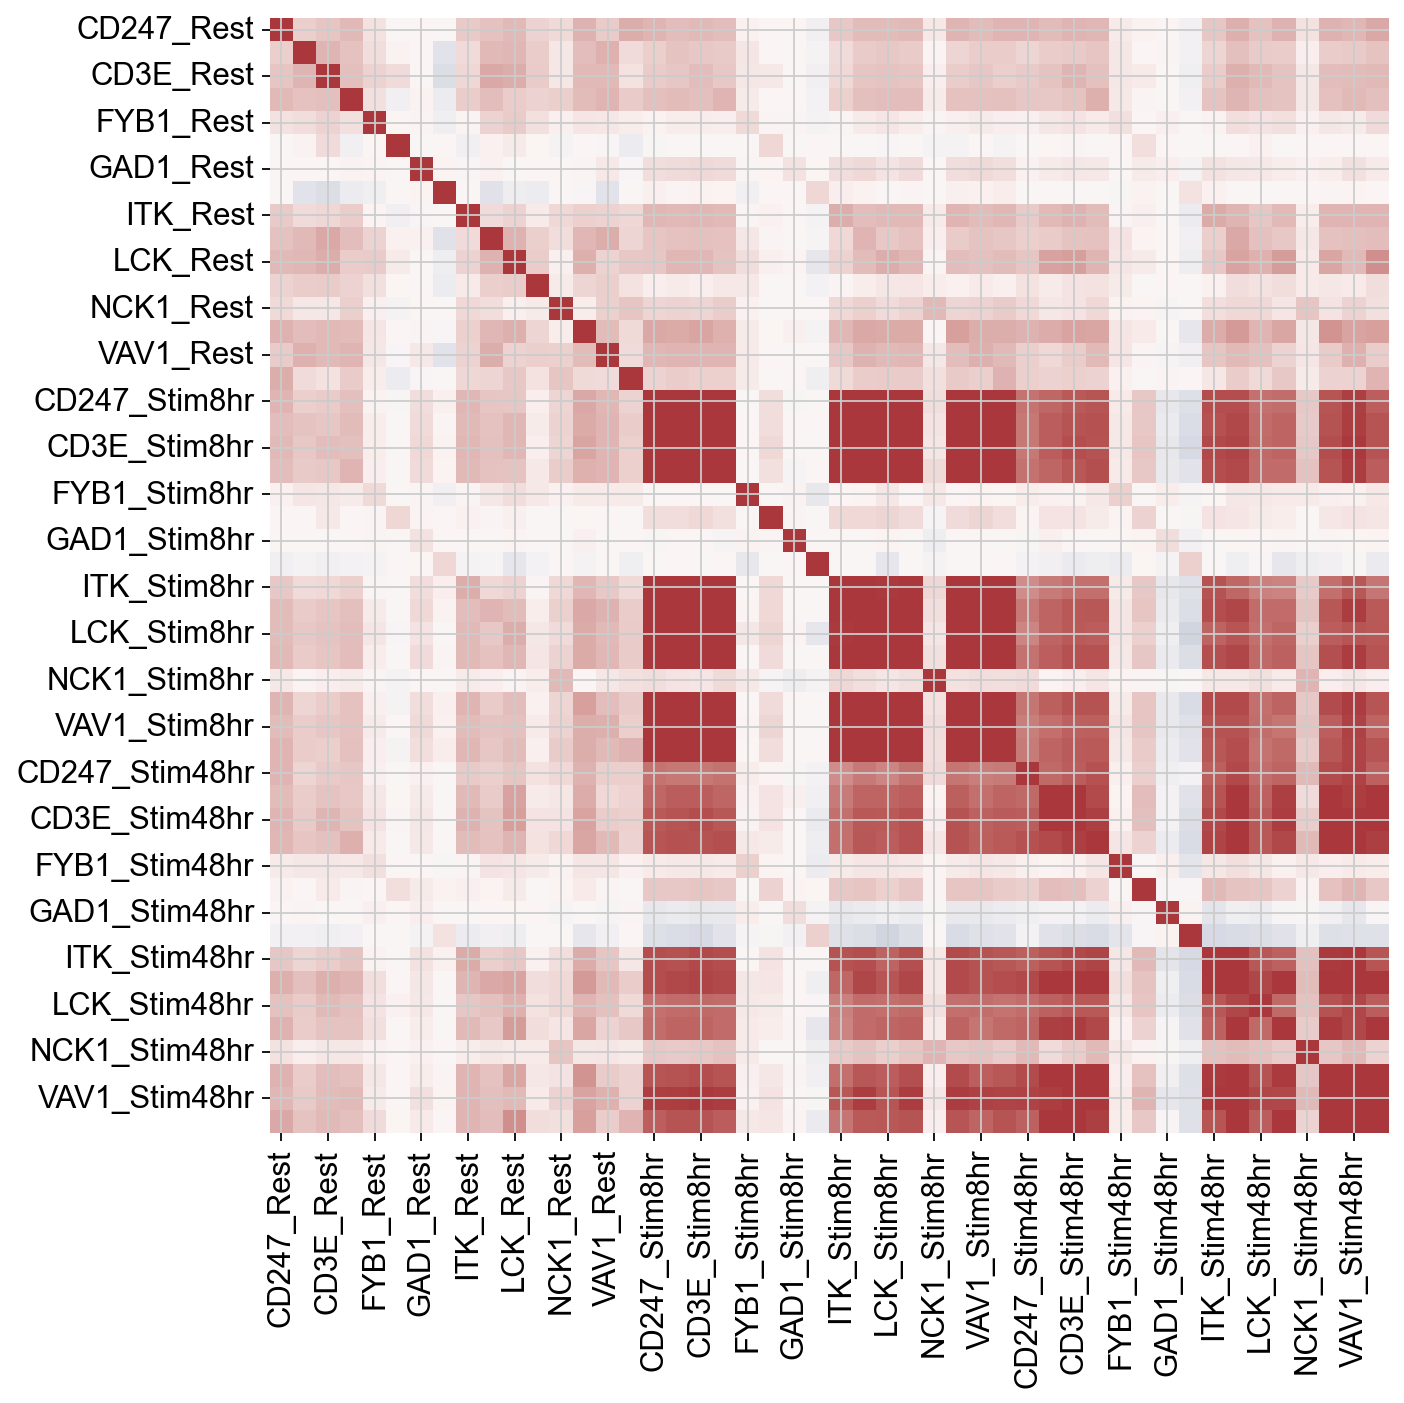

In [105]:
plt.figure(figsize=(9, 9))
genelist = adata_final[(adata_final.obs.hdbscan==29)&(adata_final.obs.target_contrast_gene_name!='BCAT2')&(adata_final.obs.target_contrast_gene_name!='ZBED3')].obs.target_contrast_gene_name_corrected.unique().tolist()
genelist = genelist + ['GRB2', 'GAD1', 'ITK', 'NCK1', 'FYB1', 'FYN', 'LCK']
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster29.png')

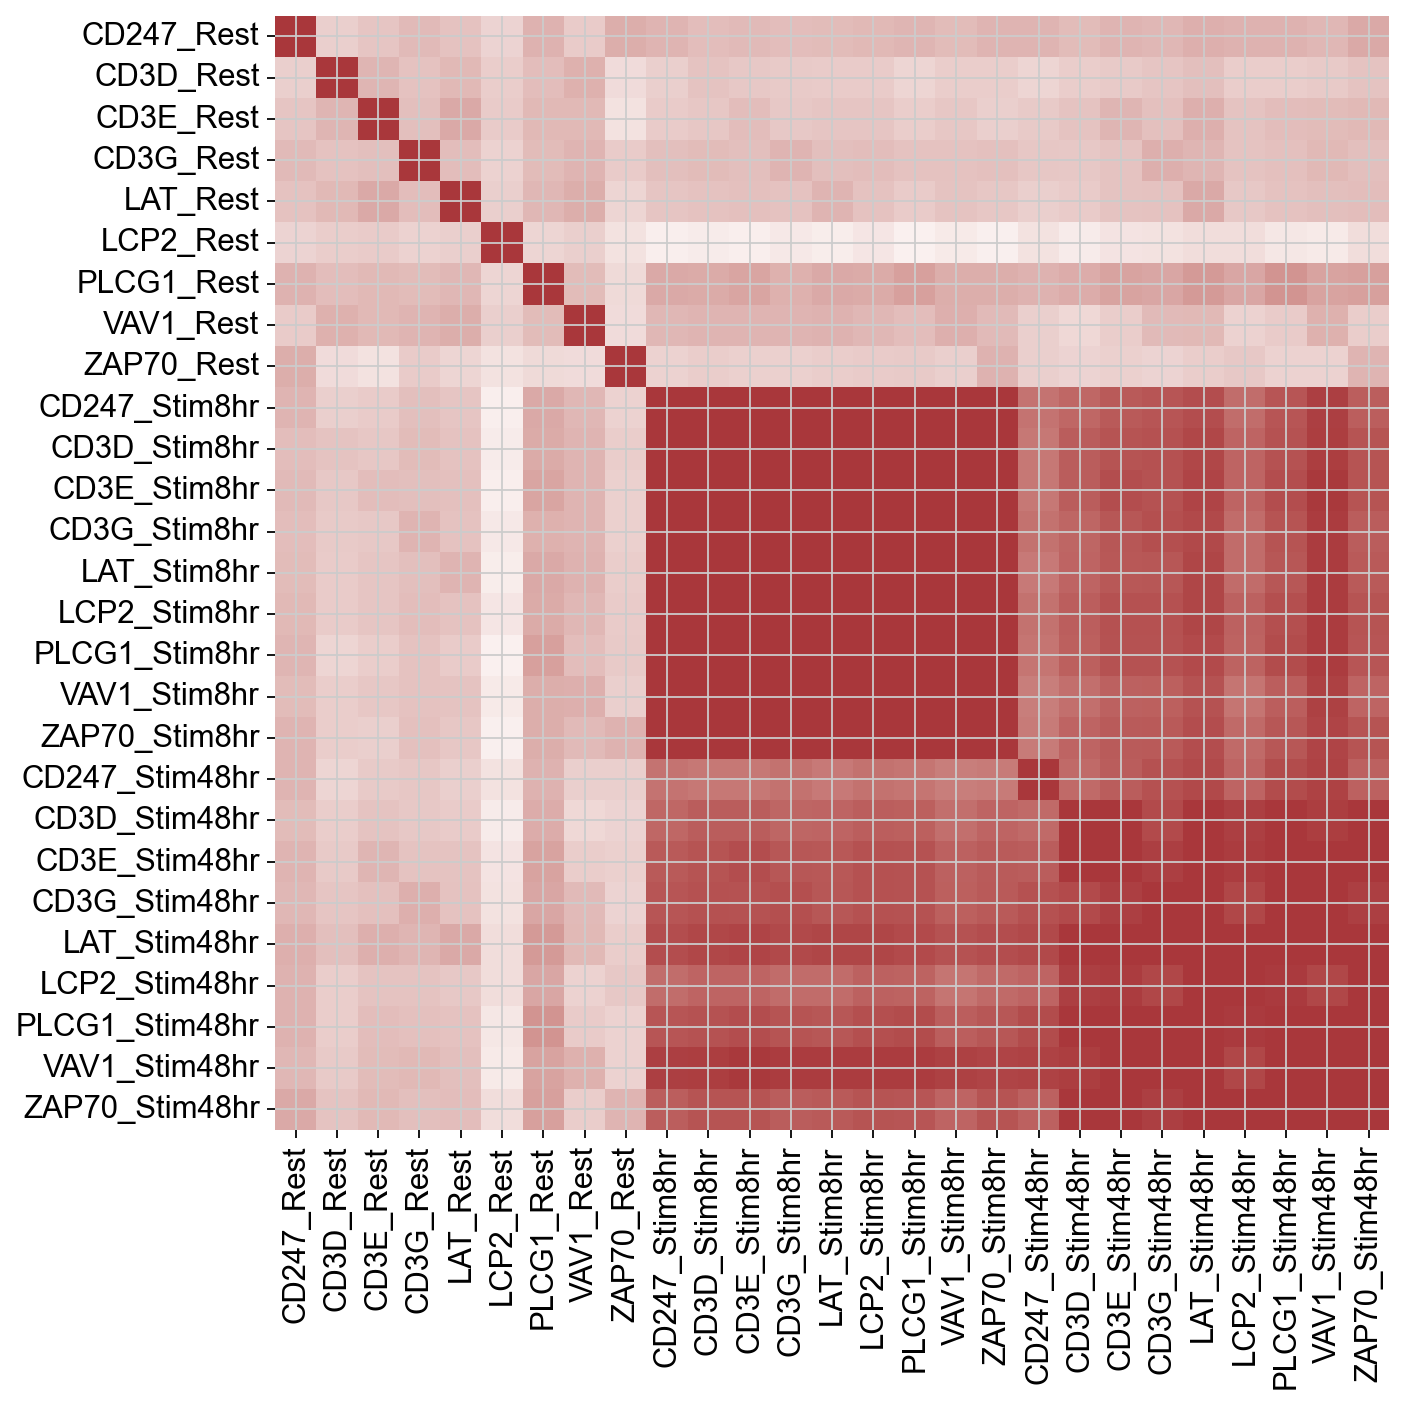

In [106]:
plt.figure(figsize=(9, 9))
genelist = adata_final[(adata_final.obs.hdbscan==29)&(adata_final.obs.target_contrast_gene_name!='BCAT2')&(adata_final.obs.target_contrast_gene_name!='ZBED3')].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster29.png')

In [44]:
de_summary_stats[de_summary_stats.target_name=='KDM5']

Empty DataFrame
Columns: [target_contrast, target_name, condition, n_cells_target, n_up_genes, n_down_genes, n_total_de_genes, ontarget_effect_size, ontarget_significant, baseMean, offtarget_flag, n_total_genes_category, ontarget_effect_category, target_contrast_corrected, obs_names, target_name_corrected]
Index: []

In [38]:
de_summary_stats[de_summary_stats.target_name=='BDH1']

target_contrast target_name condition  n_cells_target  n_up_genes  \
6623   ENSG00000161267        BDH1  Stim48hr           762.0           0   
25369  ENSG00000161267        BDH1   Stim8hr           670.0           1   
30701  ENSG00000161267        BDH1      Rest           775.0           0   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
6623              1                 1            -15.532728   
25369             1                 2            -12.591295   
30701             2                 2            -10.268499   

       ontarget_significant   baseMean  offtarget_flag n_total_genes_category  \
6623                   True  43.655616           False              1 DE gene   
25369                  True  35.456898           False          2-10 DE genes   
30701                  True  17.266753           False          2-10 DE genes   

      ontarget_effect_category target_contrast_corrected  \
6623              on-target KD           ENSG00000161267   
25369             on-target KD           ENSG00000161267   
30701             on-target KD           ENSG00000161267   

                      obs_names target_name_corrected  
6623   ENSG00000161267_Stim48hr                  BDH1  
25369   ENSG00000161267_Stim8hr                  BDH1  
30701      ENSG00000161267_Rest                  BDH1

In [35]:
adata_de[adata_de.obs.target_contrast_gene_name_corrected=='BDH1']

View of AnnData object with n_obs × n_vars = 3 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [34]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='BDH1']

View of AnnData object with n_obs × n_vars = 0 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

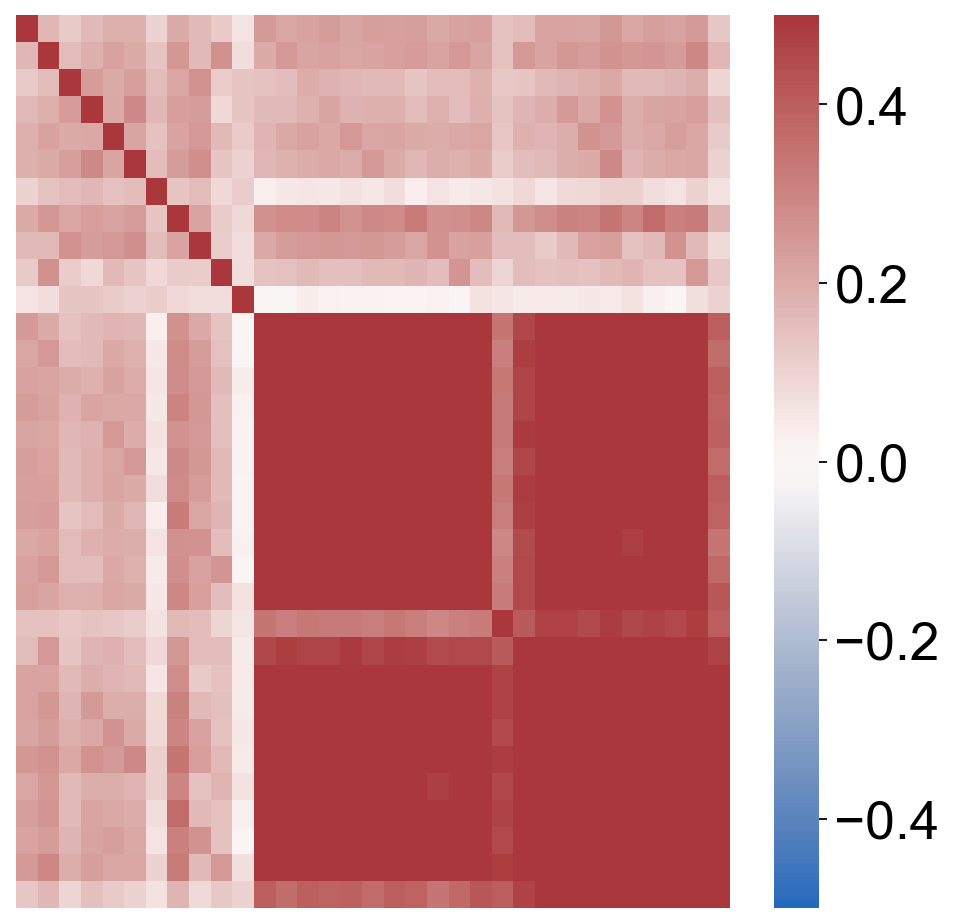

In [32]:
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==29].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
ax = sns.heatmap(corr_mtx, vmin=-0.5, vmax=0.5, cmap='vlag', xticklabels=False, yticklabels=False, cbar=True)
plt.tight_layout()
cbar = ax.collections[0].colorbar  
cbar.ax.tick_params(labelsize=24)
plt.savefig('results/colorbar0.5.png')

In [37]:
cluster_df[(cluster_df.intracluster_corr<0.2)&(cluster_df.cluster_gene_size>=5)]

cluster  intracluster_corr  cluster_size  cluster_gene_size  \
25       25           0.140295          21.0                9.0   
30       30           0.168900          16.0                8.0   
37       37           0.171560           7.0                6.0   
42       42           0.178128          11.0               11.0   
46       46           0.163973          99.0               57.0   
47       47           0.150139          15.0               15.0   
50       50           0.188514          45.0               44.0   
54       54           0.054538          45.0               27.0   
58       58           0.184500           6.0                6.0   
59       59           0.172770          40.0               40.0   
60       60           0.107564          70.0               69.0   
61       61           0.144730          27.0               19.0   
62       62           0.196344          74.0               73.0   
66       66           0.081469          12.0               12.0   
67       67           0.142190          17.0               14.0   
72       72           0.102889           7.0                7.0   
76       76           0.018664          52.0               45.0   
77       77           0.081563           8.0                5.0   
79       79           0.121424           6.0                6.0   
80       80           0.141374          11.0               11.0   
81       81           0.184018           5.0                5.0   
82       82           0.170182          17.0               17.0   
84       84           0.154942          73.0               73.0   
88       88           0.176332          21.0               21.0   
89       89           0.128020          15.0               15.0   
90       90           0.176932           5.0                5.0   
91       91           0.165445          72.0               72.0   
92       92           0.172595          10.0               10.0   
96       96           0.196787          80.0               79.0   
97       97           0.163416          14.0               14.0   

                                       cluster_member  
25  [CDKN2AIP, RBM12, WDR82, UBE3D, DNAAF2, DOP1A,...  
30  [ZFC3H1, THAP2, GPR137, ZC3H3, GPAA1, ZNF330, ...  
37         [PIBF1, BCLAF1, C1D, TTC5, FAM161A, STIM1]  
42  [PDCL, RICTOR, CBFB, POLDIP3, AGRN, EMC4, ZAP7...  
46  [TMEM131L, ACAD11, DDRGK1, CALR, ALG6, TGDS, D...  
47  [FLI1, SENP1, ELP6, EMX1, TMEM185A, MBTPS1, TM...  
50  [KLHDC10, ICOS, NEIL1, PXMP4, ZNF641, HPF1, CA...  
54  [CNOT11, TSTD2, SETD1B, PCYT2, WAC, CXXC1, KLF...  
58          [CREBBP, EP300, EME2, CBFB, KDM3B, CDCA3]  
59  [NIPBL, PXMP4, PDIA3, HSD17B13, ALKBH2, AK3, C...  
60  [IDH3A, SLC25A51, FAM20B, BRD1, PGS1, CMAS, IR...  
61  [KMT2C, RAB27B, SMARCC1, SMARCA4, SMARCB1, BHL...  
62  [FEM1A, PTPN1, NRBP1, CSK, APOBEC3B, UBXN1, CC...  
66  [MCEE, SPAG7, CWC27, PFAS, RAB27B, NAA40, ZFX,...  
67  [GIGYF2, TESPA1, TBL1X, DTX4, APOBEC3B, PRR12,...  
72  [JAKMIP2, IMMP2L, SUGP1, GCN1, ZNF254, ARL5B, ...  
76  [CDK5RAP3, NDUFB11, BLOC1S2, PAN3, SRSF6, PRPF...  
77                [CCDC6, GPR63, CARM1, ATP23, PA2G4]  
79             [PPP6C, RHEB, CYLD, CCR6, APC, POU3F1]  
80  [TMED9, TESK2, GNG5, MFSD6, SLC35B1, STK11, RB...  
81                   [SKIC3, TXNDC9, ARSK, AVEN, C1S]  
82  [CMTM7, SMAD3, AK3, RASGRP1, ICOS, ARMC8, FBXO...  
84  [ZNF574, GIGYF2, SP100, MAPK14, RRM2B, GLS, CL...  
88  [RHBDD3, MBIP, DMXL1, MTHFD1L, ZNF622, CLUH, R...  
89  [DEF8, SYNCRIP, USP10, DDX31, UBXN6, RBCK1, AT...  
90                [IPMK, PAICS, STAT3, IL21R, PABIR1]  
91  [ANKRD49, PHF3, XRCC2, STK11, RBM5, SIK3, STYX...  
92  [MFN2, PRUNE1, PPP1R11, GMEB2, UROS, DLD, TP53...  
96  [LMTK2, DUSP12, RBM27, NAF1, SARNP, CYTH3, GTF...  
97  [HSPA8, RSBN1L, SNRPB2, EIF3L, ANKRD11, PPIH, ...

In [69]:
adata_final[adata_final.obs.hdbscan==17].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000131473_Stim48hr                      ACLY          Stim48hr   
ENSG00000131473_Stim8hr                       ACLY           Stim8hr   
ENSG00000062485_Stim48hr                        CS          Stim48hr   
ENSG00000150768_Stim48hr                      DLAT          Stim48hr   
ENSG00000146701_Stim48hr                      MDH2          Stim48hr   
ENSG00000131828_Stim48hr                     PDHA1          Stim48hr   
ENSG00000168291_Stim48hr                      PDHB          Stim48hr   
ENSG00000138621_Rest                         PPCDC              Rest   
ENSG00000138621_Stim8hr                      PPCDC           Stim8hr   
ENSG00000127125_Rest                          PPCS              Rest   
ENSG00000127125_Stim8hr                       PPCS           Stim8hr   
ENSG00000100075_Stim48hr                   SLC25A1          Stim48hr   
ENSG00000127952_Stim48hr                    STYXL1          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000131473_Stim48hr  ENSG00000131473   570           282.0   
ENSG00000131473_Stim8hr   ENSG00000131473   645           396.0   
ENSG00000062485_Stim48hr  ENSG00000062485   469           232.0   
ENSG00000150768_Stim48hr  ENSG00000150768   392           372.0   
ENSG00000146701_Stim48hr  ENSG00000146701   182           998.0   
ENSG00000131828_Stim48hr  ENSG00000131828   454           192.0   
ENSG00000168291_Stim48hr  ENSG00000168291   155           303.0   
ENSG00000138621_Rest      ENSG00000138621   198           575.0   
ENSG00000138621_Stim8hr   ENSG00000138621   657           599.0   
ENSG00000127125_Rest      ENSG00000127125    41           137.0   
ENSG00000127125_Stim8hr   ENSG00000127125    97           138.0   
ENSG00000100075_Stim48hr  ENSG00000100075   102           521.0   
ENSG00000127952_Stim48hr  ENSG00000127952   671           753.0   

                         target_contrast_corrected  \
ENSG00000131473_Stim48hr           ENSG00000131473   
ENSG00000131473_Stim8hr            ENSG00000131473   
ENSG00000062485_Stim48hr           ENSG00000062485   
ENSG00000150768_Stim48hr           ENSG00000150768   
ENSG00000146701_Stim48hr           ENSG00000146701   
ENSG00000131828_Stim48hr           ENSG00000131828   
ENSG00000168291_Stim48hr           ENSG00000168291   
ENSG00000138621_Rest               ENSG00000138621   
ENSG00000138621_Stim8hr            ENSG00000138621   
ENSG00000127125_Rest               ENSG00000127125   
ENSG00000127125_Stim8hr            ENSG00000127125   
ENSG00000100075_Stim48hr           ENSG00000100075   
ENSG00000127952_Stim48hr           ENSG00000127952   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000131473_Stim48hr                                ACLY      17  
ENSG00000131473_Stim8hr                                 ACLY      17  
ENSG00000062485_Stim48hr                                  CS      17  
ENSG00000150768_Stim48hr                                DLAT      17  
ENSG00000146701_Stim48hr                                MDH2      17  
ENSG00000131828_Stim48hr                               PDHA1      17  
ENSG00000168291_Stim48hr                                PDHB      17  
ENSG00000138621_Rest                                   PPCDC      17  
ENSG00000138621_Stim8hr                                PPCDC      17  
ENSG00000127125_Rest                                    PPCS      17  
ENSG00000127125_Stim8hr                                 PPCS      17  
ENSG00000100075_Stim48hr                             SLC25A1      17  
ENSG00000127952_Stim48hr                              STYXL1      17

In [633]:
ind1 = np.where(adata.obs.index.isin(['ENSG00000181544_Stim8hr', 'ENSG00000187790_Stim8hr', 'ENSG00000112039_Stim8hr']))[0]
ind2 = np.where(adata.obs.index.isin(['ENSG00000084093_Stim8hr', 'ENSG00000126261_Stim8hr', 'ENSG00000197713_Stim8hr']))[0]
ind3 = np.where(adata.obs.index.isin(['ENSG00000106615_Rest', 'ENSG00000181754_Rest', 'ENSG00000105135_Rest']))[0]
ind = np.concatenate([ind1, ind2, ind3])
ind = np.concatenate([ind1, ind2])

ENSG00000181544_Stim8hr    0.229927
ENSG00000187790_Stim8hr    0.228583
ENSG00000112039_Stim8hr    0.226620
ENSG00000197713_Stim8hr    0.207617
ENSG00000084093_Stim8hr    0.138590
ENSG00000126261_Stim8hr    0.163671
dtype: float64


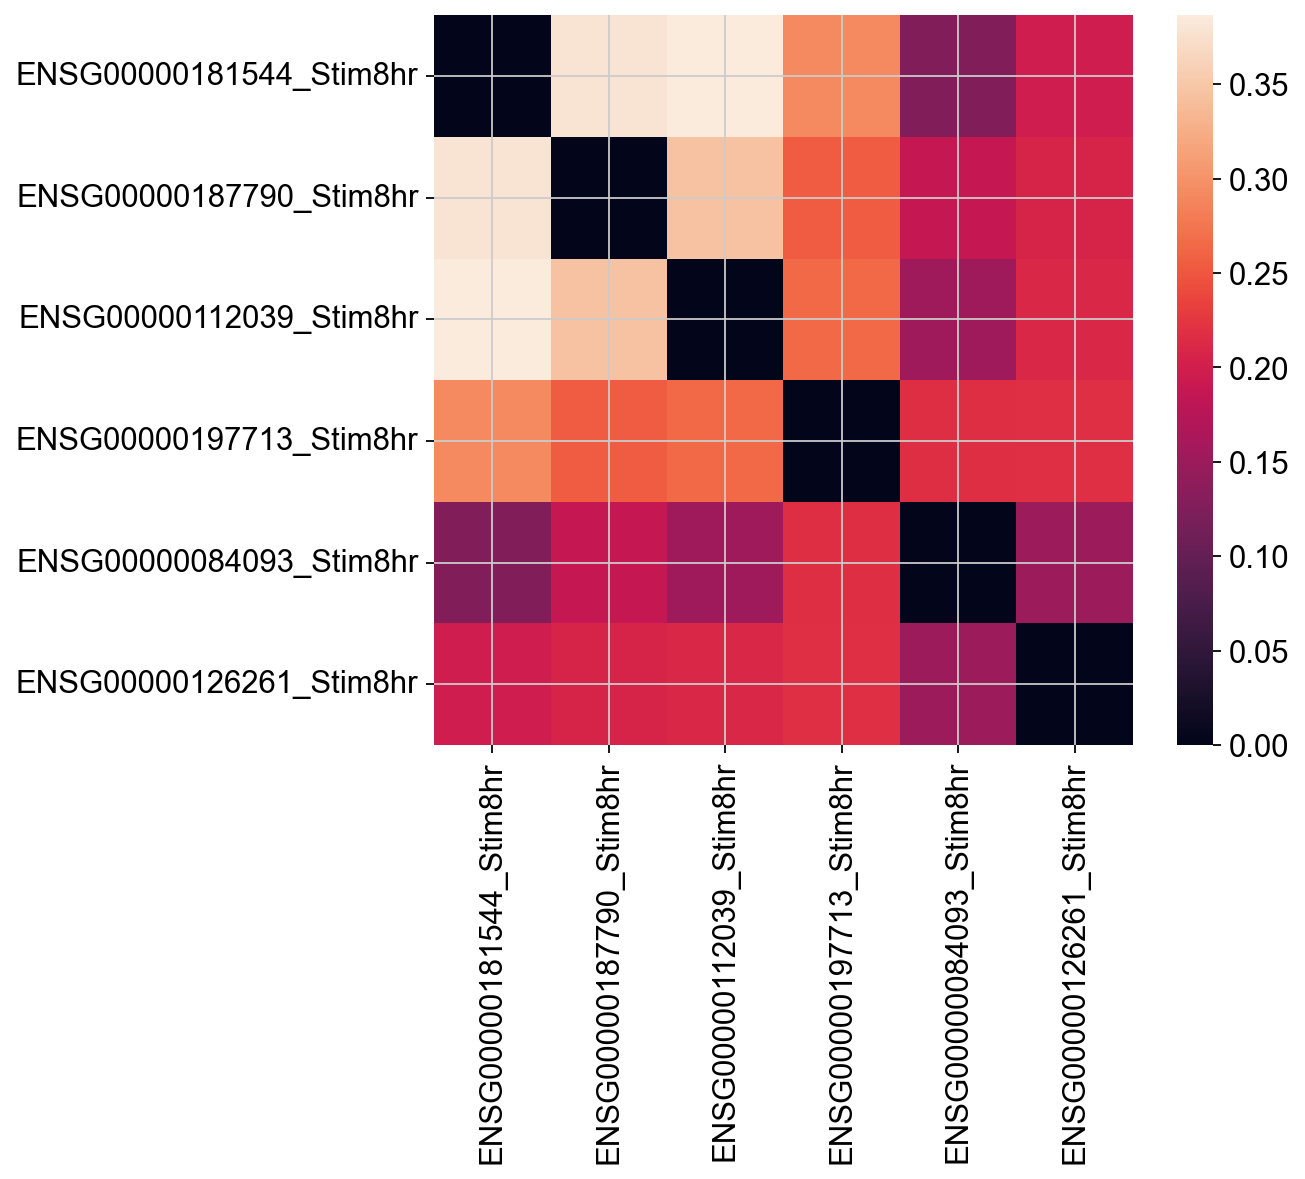

In [634]:
fig, ax = plt.subplots(figsize=(7,6))
test = pd.DataFrame(adata[ind,:].layers['zscore'].copy(),
                    index=adata[ind,:].obs.index,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, ax=ax)
print(test2.mean())